In [309]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    f_name = '../../results/figures/{}.png'.format(name)
    plt.savefig(f_name, bbox_inches='tight', dpi=300)
    print('Saving figure to {}'.format(f_name))

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Tue Jun 11 15:43:31 2019 PDT

In [209]:
from slugify import slugify

In [210]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

# Sales Forecasting
Alex's development notebook for sales forecasting.

## Read data

### Read from BigQuery

Run this cell to read from BigQuery.

In [49]:
%%time
"""
Using bigquery
"""

from google.cloud import bigquery
# Using environment variables to authenticate
client = bigquery.Client()

def pull_daily_data(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
            select
              date,
              sum(totals.visits),
              sum(totals.pageviews),
              sum(totals.transactions),
              sum(totals.transactionRevenue)
            from `bigquery-public-data.google_analytics_sample.{}`
            group by date;
        '''.format(table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_results = pull_daily_data()


CPU times: user 7.94 s, sys: 856 ms, total: 8.8 s
Wall time: 11min 29s


In [53]:
bq_results.head()

date  visits  pageviews transactions transactionRevenue
0  20160801    1711       9843           34         6116060000
1  20160802    2140      11784           18         1361190000
2  20160803    2890      13724         None               None
3  20160804    3161      13326           17         1182890000
4  20160805    2702      13585           42         5594260000

### Read `jsonl` from local

Run this cell if you have exported the data from BigQuery into JSON line (JSONL) files.

In [17]:
%%time
"""
Using local jsonl
"""
ERRORS = []

def pull_daily_data(verbose=False, raise_errors=False):
    if os.getenv('DATA_PATH') is None:
        raise ValueError('Please set environment variable DATA_PATH')

    dataset = sorted(glob.glob(os.path.join(os.getenv('DATA_PATH'), 'raw', '*.jsonl')))
    print('Loading from {}, etc...'.format(', '.join(dataset[:3])))

    data = []
    for table in tqdm_notebook(dataset):
        if verbose:
            print('Scanning {}'.format(table))
        with open(table, 'r') as f:
            table_data = []
            for line in f:
                d = json.loads(line)
                date = d['date']
                d = d['totals']
                try:
                    table_data.append([
                        date,
                        d['visits'],
                        d['pageviews'],
                        d['transactions'],
                        d['transactionRevenue'],
                    ])
                except Exception as e:
                    if verbose:
                        print('Error raised when reading row:\n{}'.format(e))
                    ERRORS.append([table, e])
                    if raise_errors:
                        raise(e)

            cols = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
            results = (
                pd.DataFrame(table_data, columns=cols)
                    .groupby('date')[['visits', 'pageviews', 'transactions', 'transactionRevenue']]
                    .sum().reset_index()
            )
            data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

jsonl_results = pull_daily_data()

Loading from /Volumes/GoogleDrive/My Drive/ga-data-mining/data/raw/ga_sessions_20160801.jsonl, /Volumes/GoogleDrive/My Drive/ga-data-mining/data/raw/ga_sessions_20160802.jsonl, /Volumes/GoogleDrive/My Drive/ga-data-mining/data/raw/ga_sessions_20160803.jsonl, etc...


CPU times: user 7min 50s, sys: 2min 9s, total: 10min
Wall time: 21min 21s


In [70]:
df = jsonl_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

Exception: File exists! Run line below in separate cell to overwrite it. Otherwise just run cell below to load file.

### Load pre-queried data

In [19]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

df = load_file('../../data/interim/sales_forecast_raw.csv')

Loading ../../data/interim/sales_forecast_raw.csv


In [20]:
df.head()

date  visits  pageviews  transactions  transactionRevenue
0 2016-08-01    1711     9843.0          34.0        6.116060e+09
1 2016-08-02    2140    11784.0          18.0        1.361190e+09
2 2016-08-03    2890    13724.0           NaN                 NaN
3 2016-08-04    3161    13326.0          17.0        1.182890e+09
4 2016-08-05    2702    13585.0          42.0        5.594260e+09

In [21]:
df['week'] = df.date.apply(lambda x: x.strftime('%W'))
df['year'] = df.date.apply(lambda x: x.strftime('%Y'))
df['week_start'] = df[['week', 'year']].apply(
    lambda x: datetime.datetime.strptime('{}-{}-1'.format(x.year, x.week), '%Y-%W-%w'),
    axis=1
)

In [22]:
df.dtypes

date                  datetime64[ns]
visits                         int64
pageviews                    float64
transactions                 float64
transactionRevenue           float64
week                          object
year                          object
week_start            datetime64[ns]
dtype: object

How does the data look? Is there seasonality that I can predict?

Note: we'll throw out the first and last week (for these charts)

In [24]:
df_ = df[(df.week_start > df.week_start.min()) & (df.week_start < df.week_start.max())].copy()

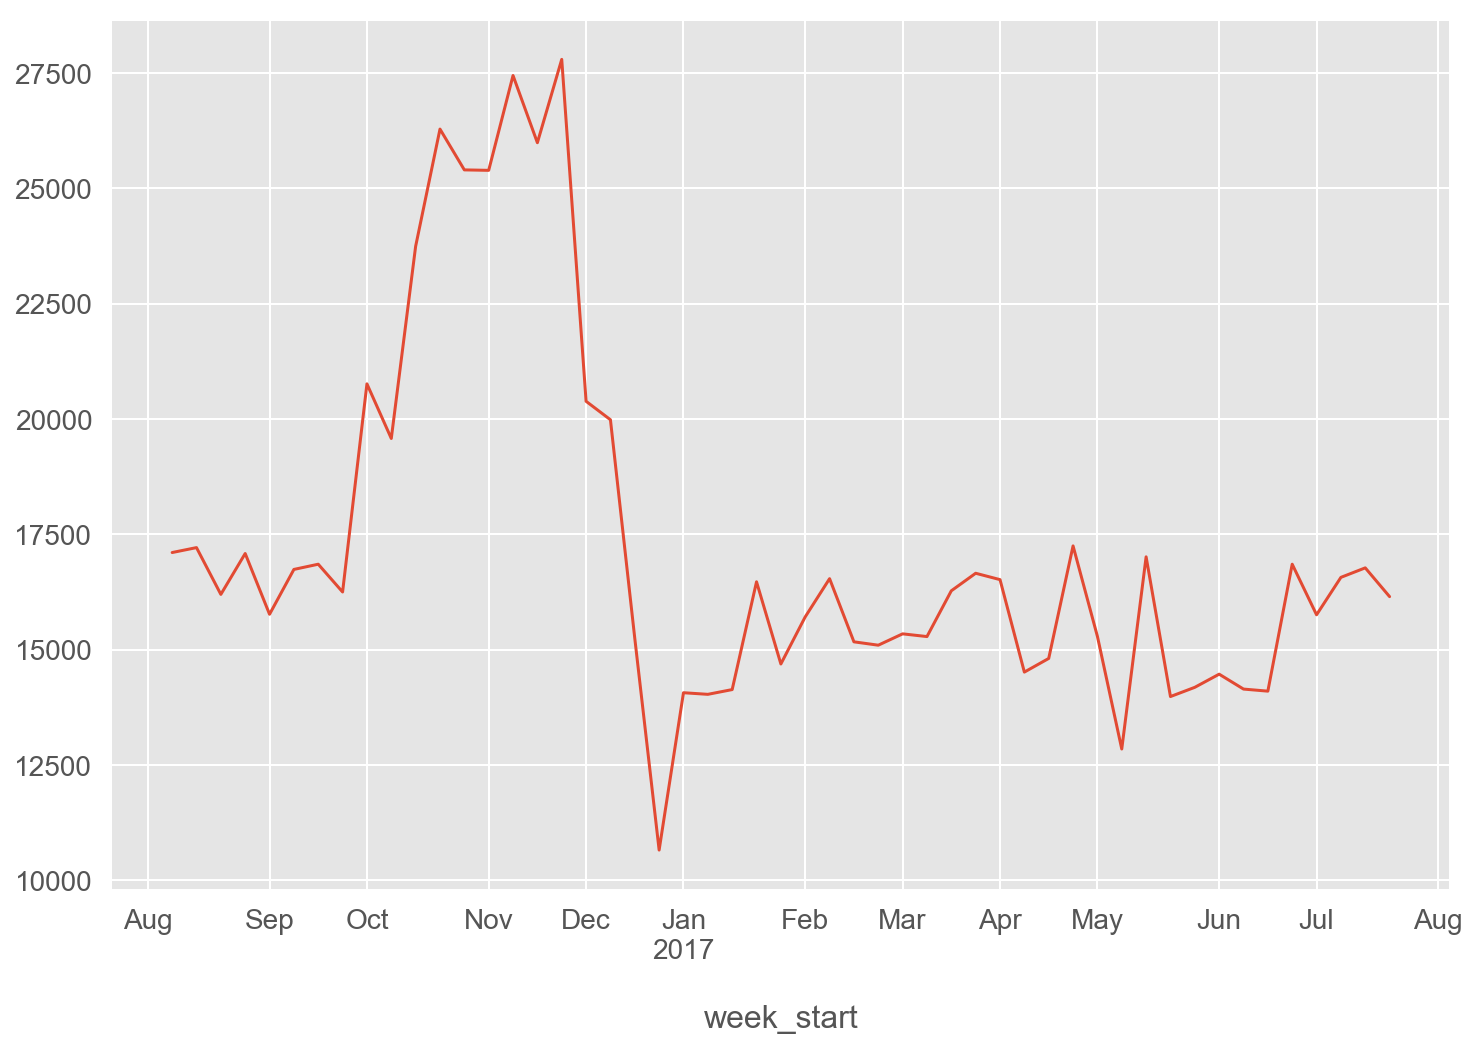

In [28]:
df_.groupby('week_start').visits.sum().plot()

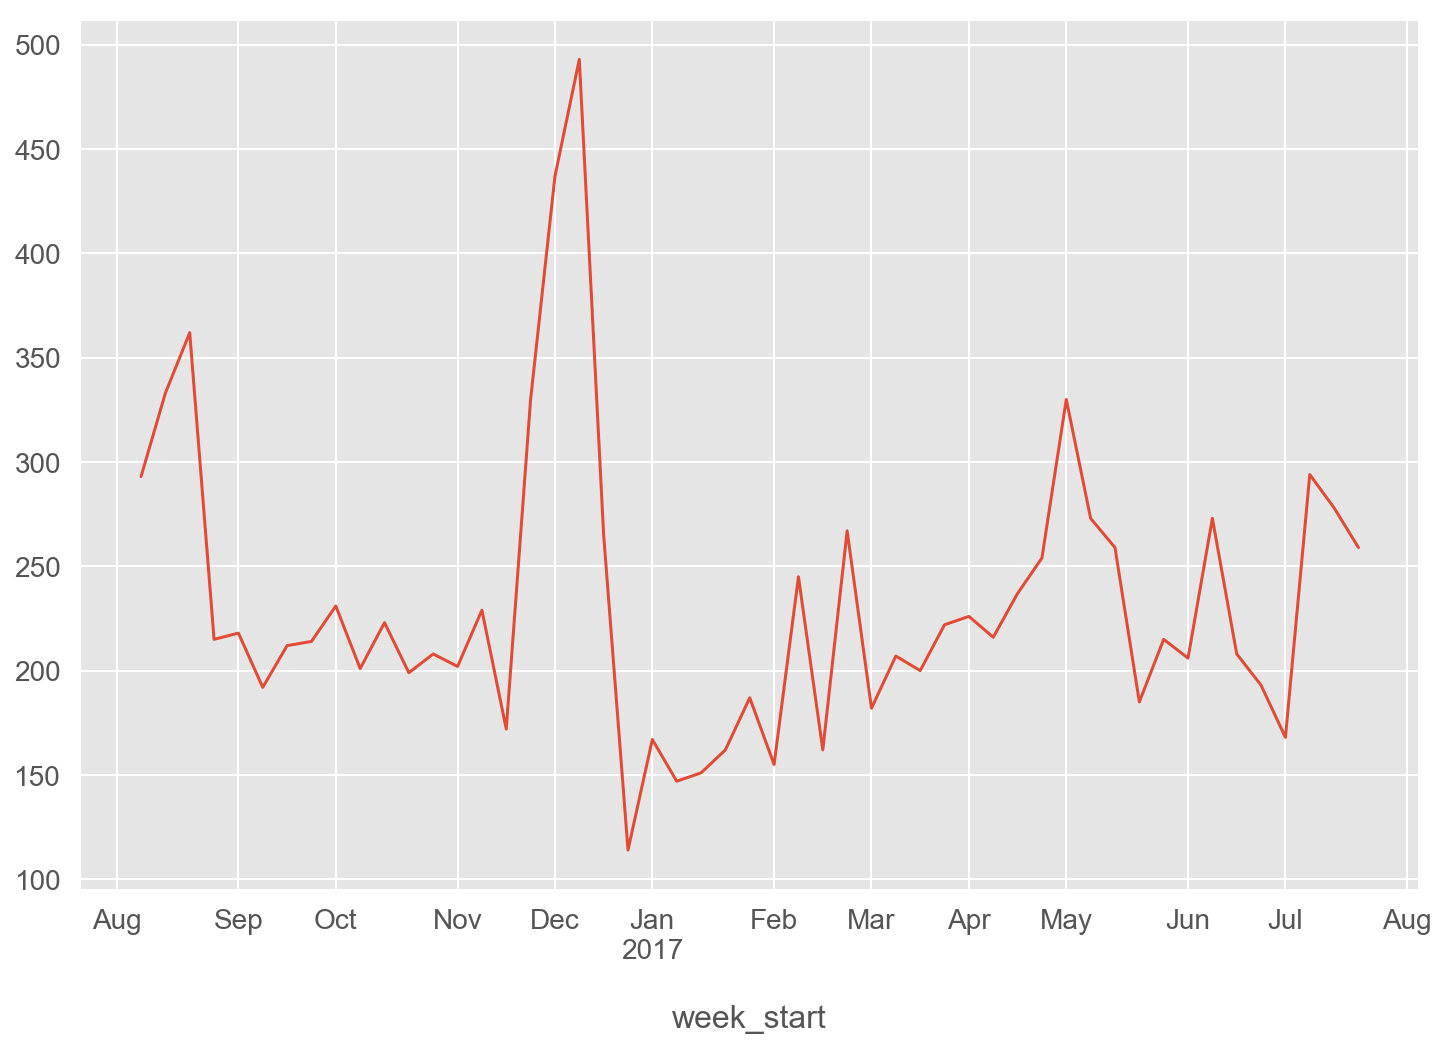

In [29]:
df_.groupby('week_start').transactions.sum().plot()

Next we'll try to forecast this trend forward. It will be difficult, since there's only one year of data to train models on.

## Forcasting with Facebook Prophet

In [30]:
from fbprophet import Prophet
import warnings
# Ignore warnings from prophet lib
warnings.filterwarnings('ignore', 'Conversion of the second argument of issubdtype')

### Transactions

Making sure to add `yearly_seasonality` as we expect yearly periodicity e.g. Christmas, black friday, etc...

Tune the parameter values (`weekly_seasonality` and `yearly_seasonality` and `seasonality_prior_scale`) to fit the given data. Higher values will lead to tighter fits (be careful about overfitting here).

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


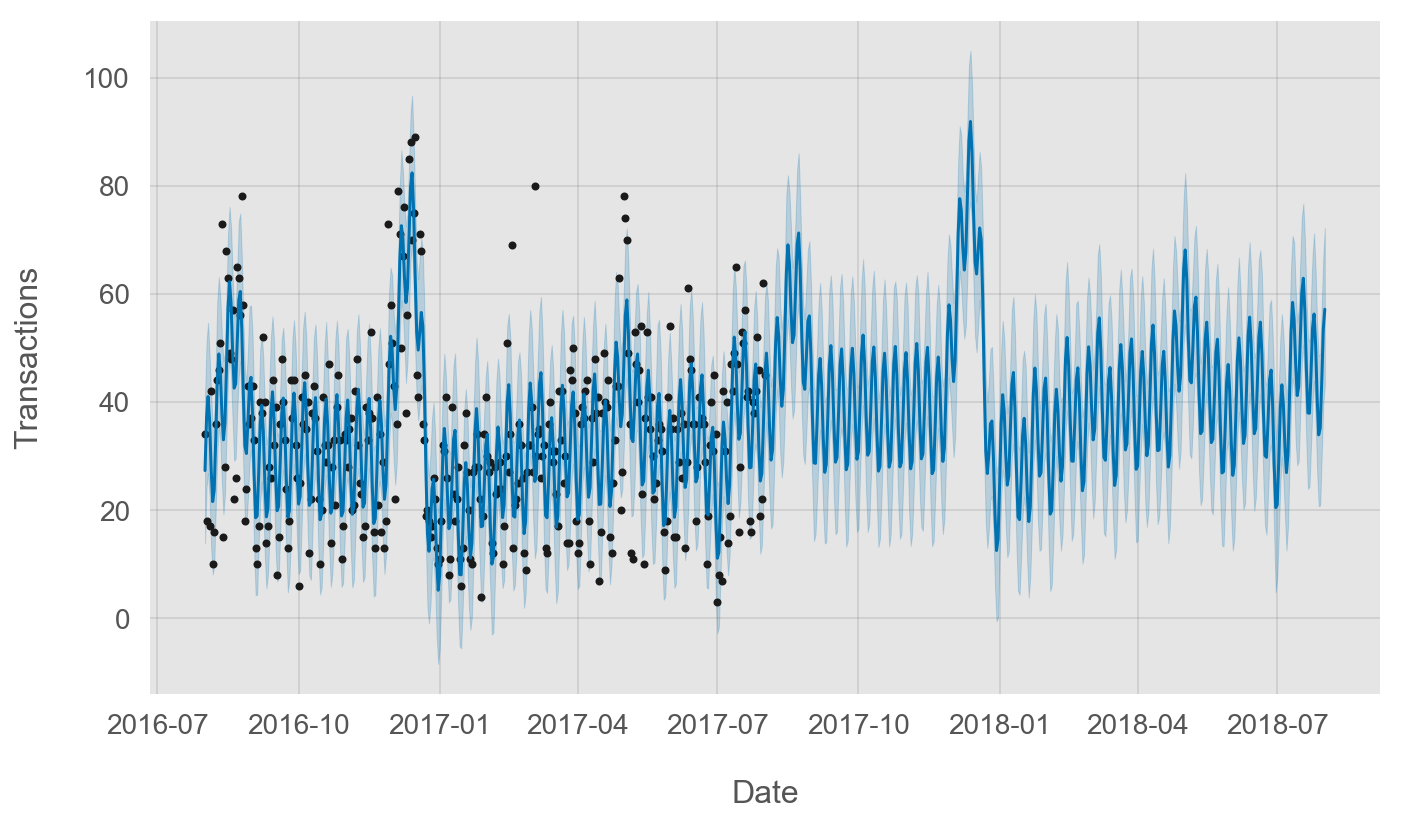

In [52]:
df_prophet = df[['date', 'transactions']]\
    .rename(columns={'date': 'ds', 'transactions': 'y'})
df_prophet['ds'] = df_prophet['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))

m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=1,
    yearly_seasonality=20,
    seasonality_prior_scale=0.1,
)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)
plt.ylabel('Transactions')
plt.xlabel('Date')
savefig('sales_forecast_transactions')

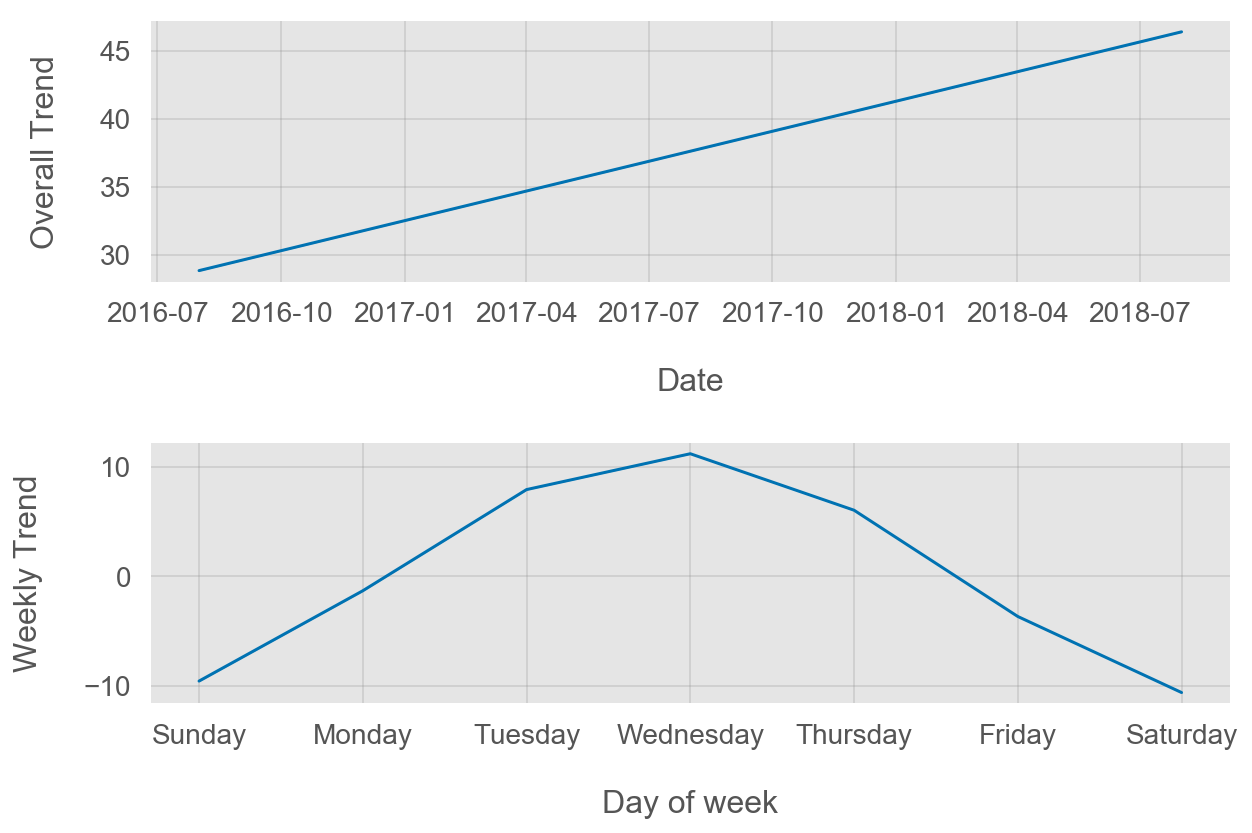

In [53]:
fig = m.plot_components(forecast)
fig.axes[0].set_xlabel('Date')
fig.axes[0].set_ylabel('Overall Trend')
fig.axes[1].set_ylabel('Weekly Trend')
fig.delaxes(fig.axes[2])
savefig('sales_forecast_transactions_trends')

### Sales

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


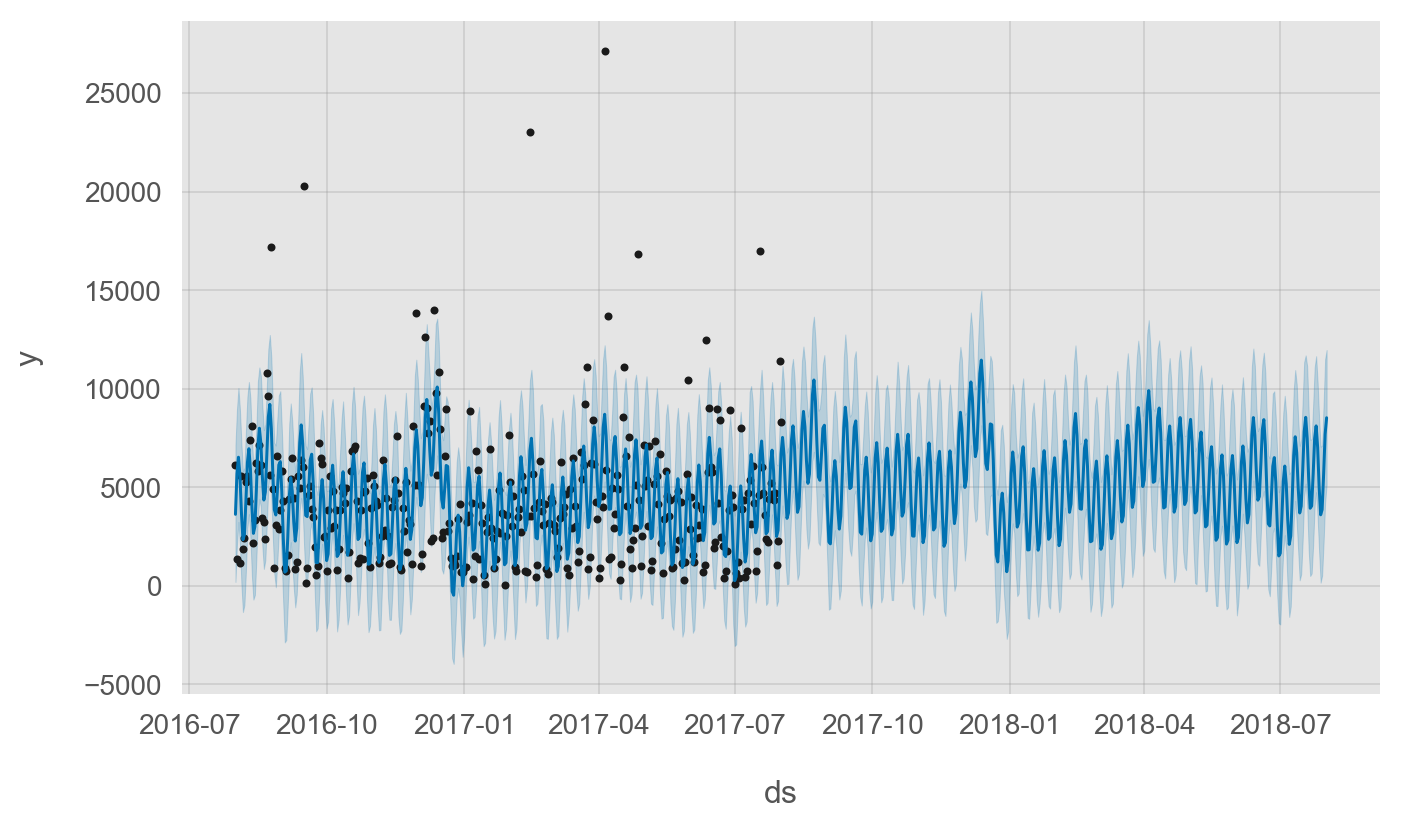

In [65]:
df_prophet = df[['date', 'transactionRevenue']]\
    .rename(columns={'date': 'ds', 'transactionRevenue': 'y'})
df_prophet['y'] = df_prophet['y'] / 1e6
df_prophet['ds'] = df_prophet['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))

m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=1,
    yearly_seasonality=20,
    seasonality_prior_scale=0.1,
)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

savefig('sales_forecast')

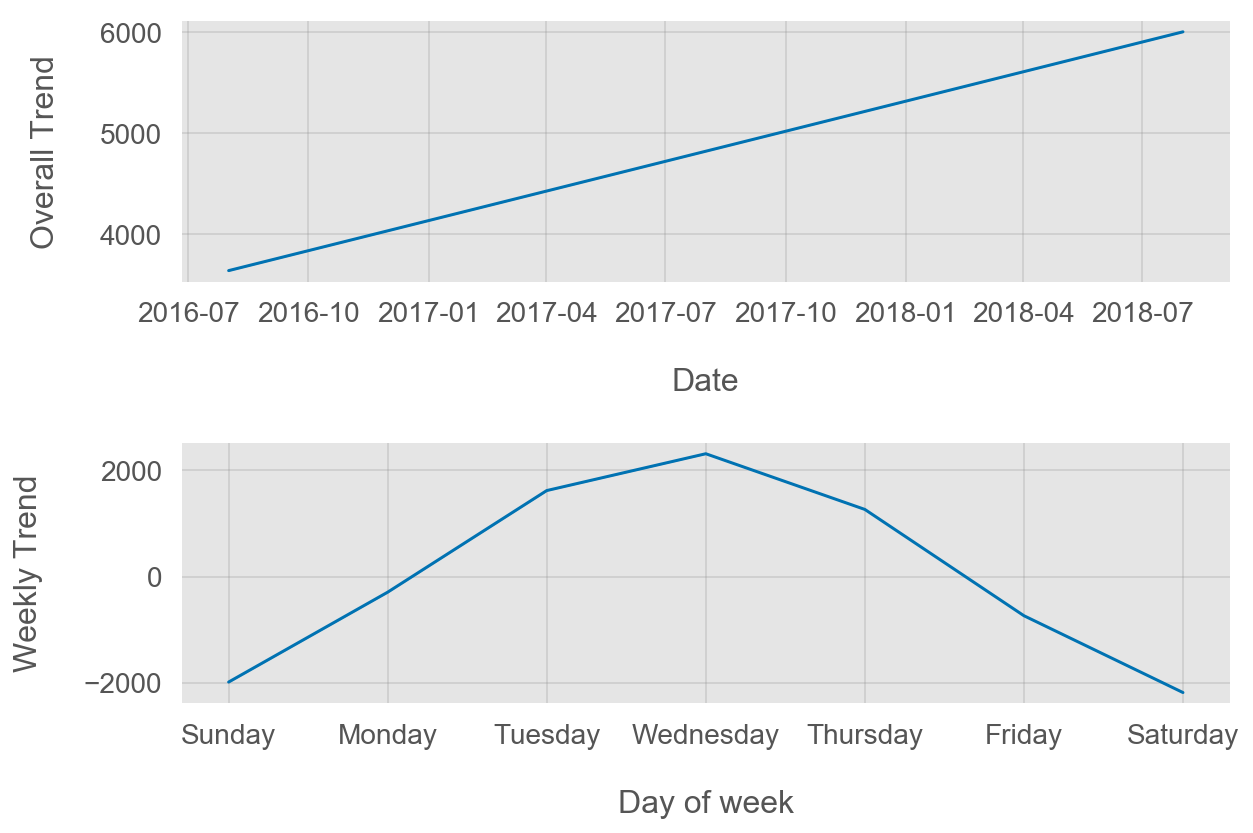

In [66]:
fig = m.plot_components(forecast)
fig.axes[0].set_xlabel('Date')
fig.axes[0].set_ylabel('Overall Trend')
fig.axes[1].set_ylabel('Weekly Trend')
fig.delaxes(fig.axes[2])
savefig('sales_forecast_trends')

### Predictions by quarter

In [55]:
forecast['date'] = pd.to_datetime(forecast['ds'])

In [57]:
def add_quarters(df):
    """
    Add labels for quarter number. May need to adjust for specific
    fiscal calendar. Only covers until end of 2018.
    
    df : pd.DataFrame
        Should have "date" column that is datetime dtype.
    """
    df['quarter'] = float('nan')
    df['quarter_num'] = float('nan')
    
    df.loc[(df.date >= datetime.datetime(2016, 7, 1))&(df.date < datetime.datetime(2016, 10, 1)), 'quarter'] = '2016 Q3'
    df.loc[(df.date >= datetime.datetime(2016, 10, 1))&(df.date < datetime.datetime(2017, 1, 1)), 'quarter'] = '2016 Q4'
    df.loc[(df.date >= datetime.datetime(2017, 1, 1))&(df.date < datetime.datetime(2017, 4, 1)), 'quarter'] = '2017 Q1'
    df.loc[(df.date >= datetime.datetime(2017, 4, 1))&(df.date < datetime.datetime(2017, 7, 1)), 'quarter'] = '2017 Q2'
    df.loc[(df.date >= datetime.datetime(2017, 7, 1))&(df.date < datetime.datetime(2017, 10, 1)), 'quarter'] = '2017 Q3'
    df.loc[(df.date >= datetime.datetime(2017, 10, 1))&(df.date < datetime.datetime(2018, 1, 1)), 'quarter'] = '2017 Q4'
    df.loc[(df.date >= datetime.datetime(2018, 1, 1))&(df.date < datetime.datetime(2018, 4, 1)), 'quarter'] = '2018 Q1'
    df.loc[(df.date >= datetime.datetime(2018, 4, 1))&(df.date < datetime.datetime(2018, 7, 1)), 'quarter'] = '2018 Q2'
    df.loc[(df.date >= datetime.datetime(2018, 7, 1))&(df.date < datetime.datetime(2018, 10, 1)), 'quarter'] = '2018 Q3'
    df.loc[(df.date >= datetime.datetime(2018, 10, 1))&(df.date < datetime.datetime(2019, 1, 1)), 'quarter'] = '2018 Q4'

    df.loc[(df.date >= datetime.datetime(2016, 7, 1))&(df.date < datetime.datetime(2016, 10, 1)), 'quarter_num'] = 1
    df.loc[(df.date >= datetime.datetime(2016, 10, 1))&(df.date < datetime.datetime(2017, 1, 1)), 'quarter_num'] = 2
    df.loc[(df.date >= datetime.datetime(2017, 1, 1))&(df.date < datetime.datetime(2017, 4, 1)), 'quarter_num'] = 3
    df.loc[(df.date >= datetime.datetime(2017, 4, 1))&(df.date < datetime.datetime(2017, 7, 1)), 'quarter_num'] = 4
    df.loc[(df.date >= datetime.datetime(2017, 7, 1))&(df.date < datetime.datetime(2017, 10, 1)), 'quarter_num'] = 5
    df.loc[(df.date >= datetime.datetime(2017, 10, 1))&(df.date < datetime.datetime(2018, 1, 1)), 'quarter_num'] = 6
    df.loc[(df.date >= datetime.datetime(2018, 1, 1))&(df.date < datetime.datetime(2018, 4, 1)), 'quarter_num'] = 7
    df.loc[(df.date >= datetime.datetime(2018, 4, 1))&(df.date < datetime.datetime(2018, 7, 1)), 'quarter_num'] = 8
    df.loc[(df.date >= datetime.datetime(2018, 7, 1))&(df.date < datetime.datetime(2018, 10, 1)), 'quarter_num'] = 9
    df.loc[(df.date >= datetime.datetime(2018, 10, 1))&(df.date < datetime.datetime(2019, 1, 1)), 'quarter_num'] = 10
    return df

In [58]:
forecast = add_quarters(forecast)

In [59]:
forecast.quarter.value_counts()

2016 Q4    92
2017 Q3    92
2017 Q4    92
2018 Q2    91
2017 Q2    91
2018 Q1    90
2017 Q1    90
2016 Q3    61
2018 Q3    32
Name: quarter, dtype: int64

For the Google Merch Store, we only have partial data for 2016 & 2018 Q3, so we'll want to filter these out.

In [62]:
m_google_merch = (forecast.quarter != '2016 Q3') & (forecast.quarter != '2018 Q3')

s_transactionRevenue = (
    forecast[m_google_merch].groupby(['quarter_num', 'quarter'])
        .yhat.sum().reset_index()
        .set_index('quarter_num').sort_index(ascending=True)
        .set_index('quarter')['yhat']
)

# Print it
s_transactionRevenue.apply(lambda x: '${:,}'.format(round(x)))

quarter
2016 Q4    $385,919
2017 Q1    $341,650
2017 Q2    $399,708
2017 Q3    $486,170
2017 Q4    $495,440
2018 Q1    $447,201
2018 Q2    $508,503
Name: yhat, dtype: object

Display these results in a dataframe

In [63]:
# Get the actual sales (as opposed to predicted above)

df = add_quarters(df)
m_google_merch = (df.quarter != '2016 Q3') & (df.quarter != '2018 Q3')
s_actual_transactionRevenue = (
    df[m_google_merch].groupby(['quarter_num', 'quarter'])
        .transactionRevenue.sum().reset_index()
        .set_index('quarter_num').sort_index(ascending=True)
        .set_index('quarter')['transactionRevenue'] / 1e6
)

# Print it
s_actual_transactionRevenue.apply(lambda x: '${:,}'.format(round(x)))

quarter
2016 Q4    $386,901
2017 Q1    $337,599
2017 Q2    $402,070
2017 Q3    $132,804
Name: transactionRevenue, dtype: object

Generate a YoY table view

In [67]:
forecast_results = pd.DataFrame({
    'Reporting Period': ['Q4', 'Q1', 'Q2'],
    'Prev Year': [
        s_actual_transactionRevenue[s_actual_transactionRevenue.index=='2016 Q4'].values[0] if (s_actual_transactionRevenue.index=='2016 Q4').sum() else 0,
        s_actual_transactionRevenue[s_actual_transactionRevenue.index=='2017 Q1'].values[0] if (s_actual_transactionRevenue.index=='2017 Q1').sum() else 0,
        s_actual_transactionRevenue[s_actual_transactionRevenue.index=='2017 Q2'].values[0] if (s_actual_transactionRevenue.index=='2017 Q2').sum() else 0,
    ],
    'Forecasted': [
        s_transactionRevenue[s_transactionRevenue.index=='2017 Q4'].values[0],
        s_transactionRevenue[s_transactionRevenue.index=='2018 Q1'].values[0],
        s_transactionRevenue[s_transactionRevenue.index=='2018 Q2'].values[0],
    ],
})
forecast_results['YoY (%)'] = ((forecast_results['Forecasted'] - forecast_results['Prev Year'])
                                / forecast_results['Prev Year'] * 100).apply(lambda x: '{:+.0f}%'.format(x))
forecast_results['Prev Year'] = forecast_results['Prev Year'].apply(lambda x: '${:,.0f}'.format(x))
forecast_results['Forecasted'] = forecast_results['Forecasted'].apply(lambda x: '${:,.0f}'.format(x))
forecast_results.set_index('Reporting Period', inplace=True)
forecast_results.to_csv('../../results/tables/sales_forecast.csv')


In [68]:
forecast_results

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                $386,901   $495,440    +28%
Q1                $337,599   $447,201    +32%
Q2                $402,070   $508,503    +26%

## Forecasting by device, region, source, etc...

The Google Merch Store dataset in BigQuery gives limited access to segmentation variables. Some interesting options we do have access to are device, region and traffic source.

### Read from BigQuery

Run this cell to read from BigQuery.

In [215]:
%%time
"""
Using bigquery
"""

from google.cloud import bigquery
# Using environment variables to authenticate
client = bigquery.Client()

def pull_daily_data(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
            select
              date,
              sum(totals.visits),
              sum(totals.pageviews),
              sum(totals.transactions),
              sum(totals.transactionRevenue),
              trafficSource.source as source,
              device.deviceCategory as deviceCategory,
              geoNetwork.country as country,
              geoNetwork.region as region
            from `bigquery-public-data.google_analytics_sample.{}`
            group by date, source, deviceCategory, country, region;
        '''.format(table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue',
                           'source', 'deviceCategory', 'country', 'region']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_results = pull_daily_data()

CPU times: user 14.2 s, sys: 1.86 s, total: 16.1 s
Wall time: 13min 31s


In [216]:
bq_results.head()

date  visits  pageviews transactions transactionRevenue  \
0  20160801       3        4.0          NaN                NaN   
1  20160801       1        2.0          NaN                NaN   
2  20160801       1        1.0          NaN                NaN   
3  20160801       3        3.0          NaN                NaN   
4  20160801       1        1.0          NaN                NaN   

           source deviceCategory            country  \
0     youtube.com        desktop  Macedonia (FYROM)   
1  squishable.com         mobile              Japan   
2     youtube.com        desktop             Cyprus   
3        (direct)        desktop          Singapore   
4        (direct)         mobile              China   

                          region  
0  not available in demo dataset  
1  not available in demo dataset  
2                      (not set)  
3  not available in demo dataset  
4  not available in demo dataset

In [217]:
df = bq_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_segments_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

### Load pre-queried data

In [219]:
def load_file(f_path):
    if not os.path.exists(f_path):
        raise Exception('No data found. Run data load script above.')
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_segments_raw.csv')
df = load_file(f_path)

Loading /Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/sales_forecast_segments_raw.csv


In [220]:
df.head()

date  visits  pageviews  transactions  transactionRevenue  \
0 2016-08-01       3        4.0           NaN                 NaN   
1 2016-08-01       1        2.0           NaN                 NaN   
2 2016-08-01       1        1.0           NaN                 NaN   
3 2016-08-01       3        3.0           NaN                 NaN   
4 2016-08-01       1        1.0           NaN                 NaN   

           source deviceCategory            country  \
0     youtube.com        desktop  Macedonia (FYROM)   
1  squishable.com         mobile              Japan   
2     youtube.com        desktop             Cyprus   
3        (direct)        desktop          Singapore   
4        (direct)         mobile              China   

                          region  
0  not available in demo dataset  
1  not available in demo dataset  
2                      (not set)  
3  not available in demo dataset  
4  not available in demo dataset

In [221]:
df['week'] = df.date.apply(lambda x: x.strftime('%W'))
df['year'] = df.date.apply(lambda x: x.strftime('%Y'))
df['week_start'] = df[['week', 'year']].apply(
    lambda x: datetime.datetime.strptime('{}-{}-1'.format(x.year, x.week), '%Y-%W-%w'),
    axis=1
)

In [222]:
df.dtypes

date                  datetime64[ns]
visits                         int64
pageviews                    float64
transactions                 float64
transactionRevenue           float64
source                        object
deviceCategory                object
country                       object
region                        object
week                          object
year                          object
week_start            datetime64[ns]
dtype: object

In [223]:
df_ = df[(df.week_start > df.week_start.min()) & (df.week_start < df.week_start.max())].copy()

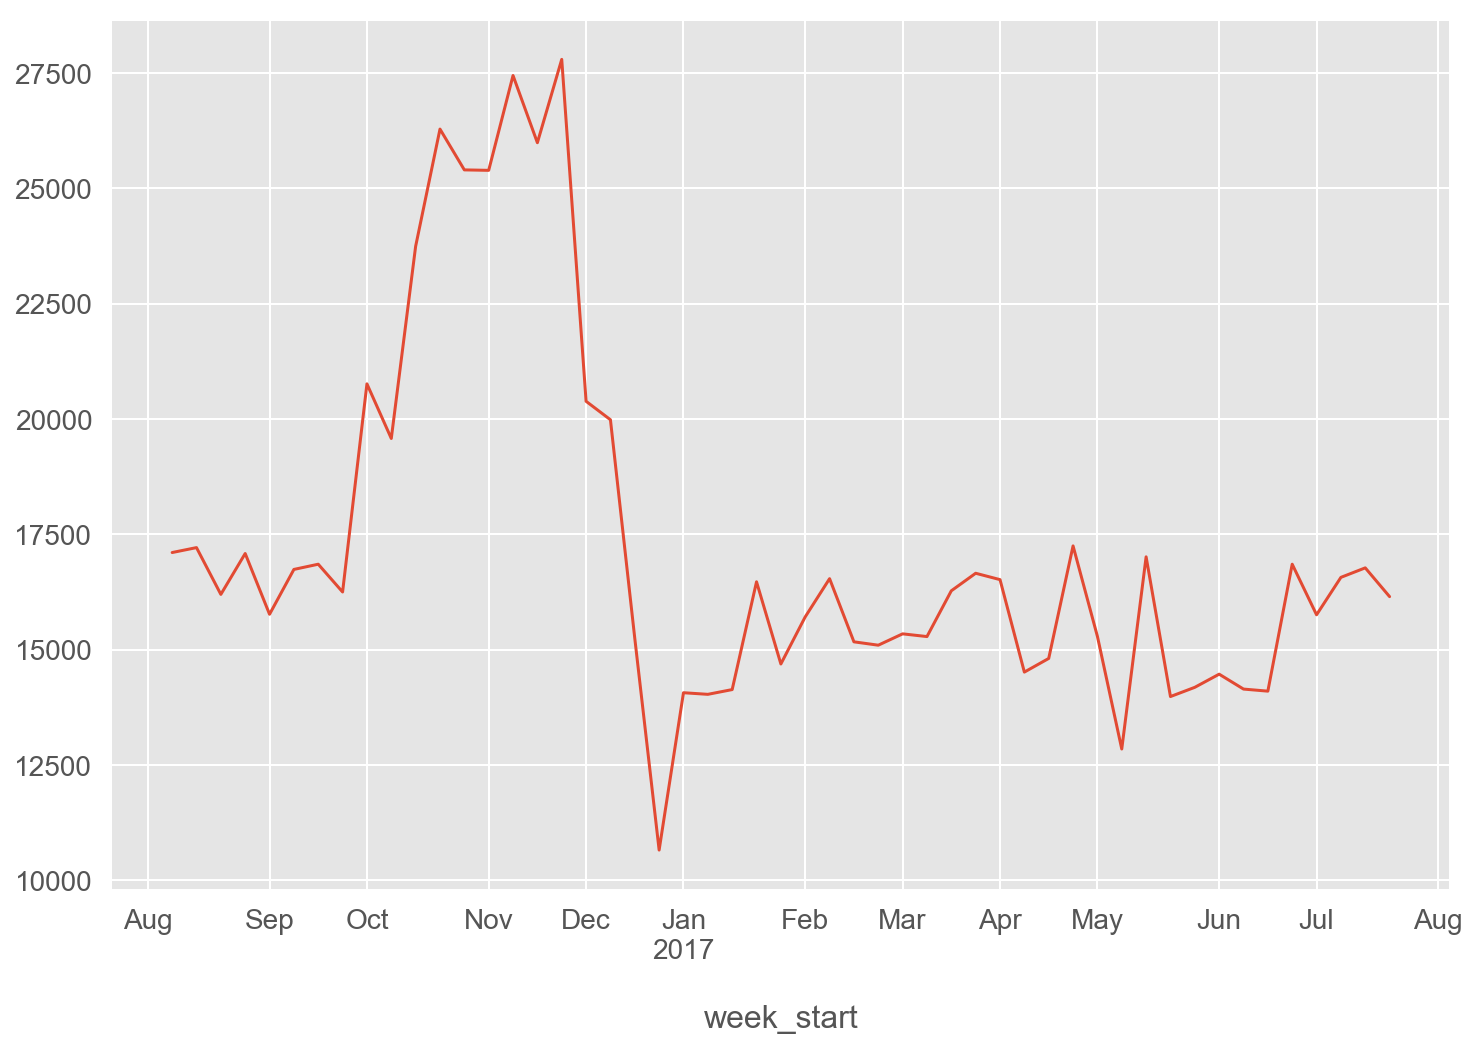

In [224]:
df_.groupby('week_start').visits.sum().plot()

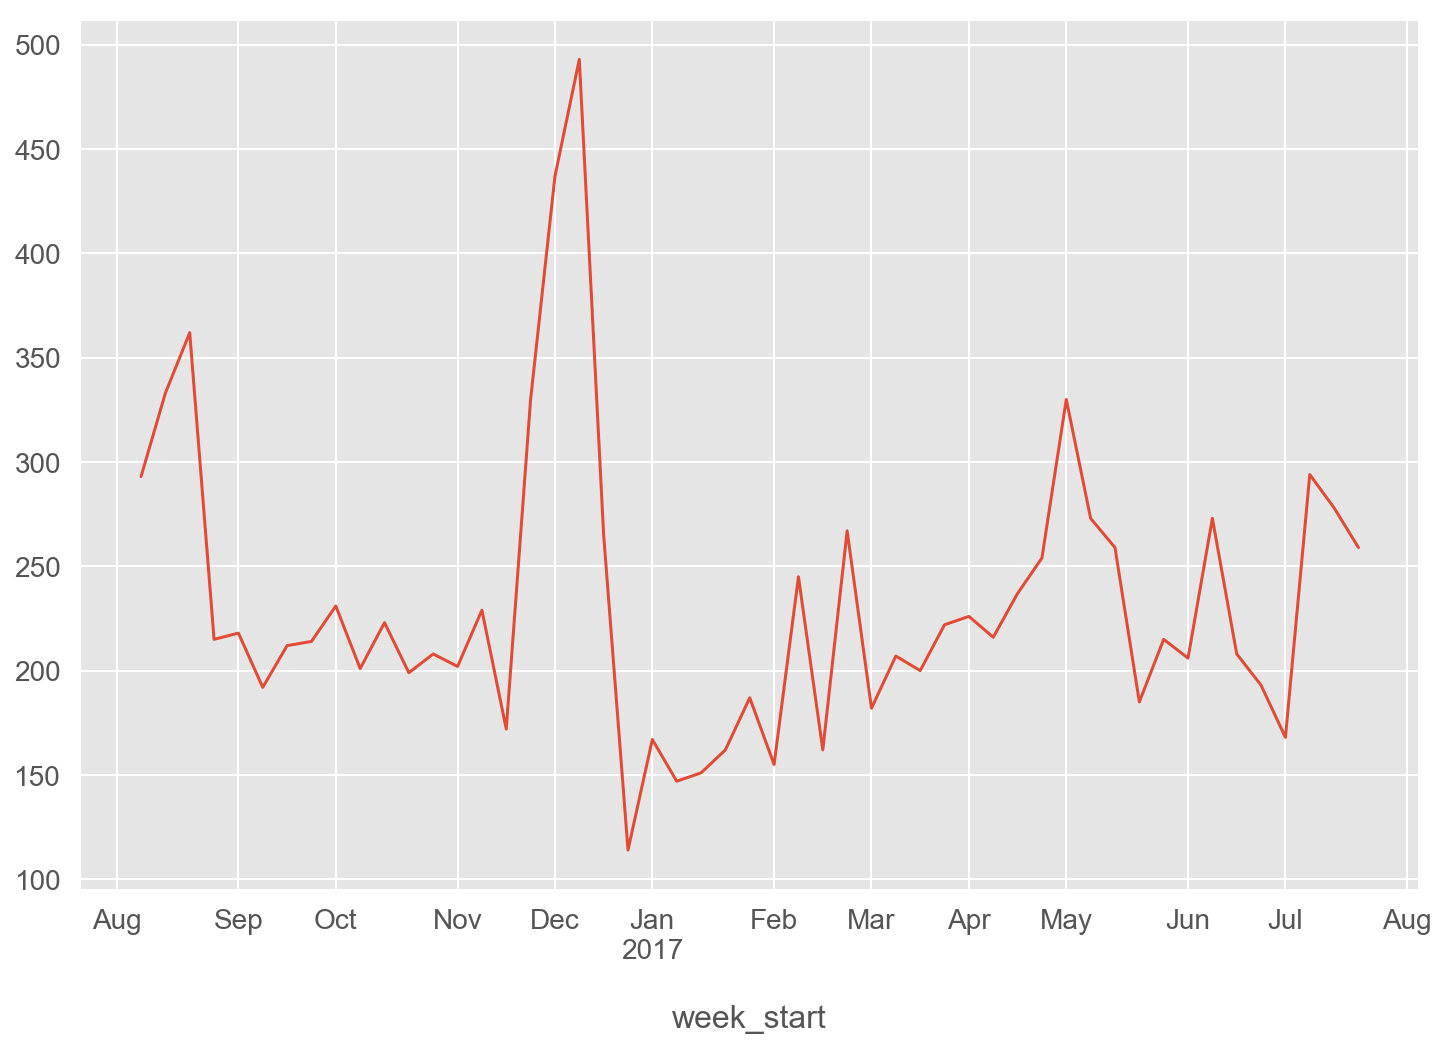

In [225]:
df_.groupby('week_start').transactions.sum().plot()

Next we'll try to forecast this trend forward. It will be difficult, since there's only one year of data to train models on.

### Forcasting with Transactions

In [226]:
from fbprophet import Prophet
import warnings
# Ignore warnings from prophet lib
warnings.filterwarnings('ignore', 'Conversion of the second argument of issubdtype')

Making sure to add `yearly_seasonality` as we expect yearly periodicity e.g. Christmas, black friday, etc...

Tune the parameter values (`weekly_seasonality` and `yearly_seasonality` and `seasonality_prior_scale`) to fit the given data. Higher values will lead to tighter fits (be careful about overfitting here).

In [244]:
Prophet.plot?

In [329]:
def build_prophet_df(df, segment_col):
    df_prophet = (
        df.groupby(['date', segment_col]).transactions.sum()
        .reset_index()
        .rename(columns={'transactions': 'y'})
    )
    df_prophet['ds'] = df_prophet['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df_prophet = df_prophet.sort_values('date', ascending=True)
    return df_prophet

def segment_forecast_daily(
    df,
    segment_col,
    max_num_segments=6,
    daily_seasonality=False,
    weekly_seasonality=2,
    yearly_seasonality=10,
    seasonality_prior_scale=0.1,
):
    df_prophet = build_prophet_df(df, segment_col)
    
    segs = (
        df_prophet.groupby(segment_col)['y'].sum()
        .sort_values(ascending=False)
        .head(max_num_segments).index.tolist()
    )
    models = []
    forecasts = []
    for seg in segs:
        m = Prophet(
            daily_seasonality=daily_seasonality,
            weekly_seasonality=weekly_seasonality,
            yearly_seasonality=yearly_seasonality,
            seasonality_prior_scale=seasonality_prior_scale,
        )
        m.fit(df_prophet[df_prophet[segment_col] == seg])
        models.append(m)
        
        future = m.make_future_dataframe(periods=365, freq='D')
        forecast = m.predict(future)
        forecasts.append(forecast)
        
    colors = list('rbgykmc') * 10
    fig, axes = plt.subplots(len(forecasts), sharex=True)
    for i, (ax, seg, forecast, c) in enumerate(zip(axes, segs, forecasts, colors)):
        forecast.set_index('ds')['yhat'].plot(label=seg, ax=ax, color=c)
        (df_prophet[df_prophet[segment_col] == seg]
         .set_index('date')['y'].plot(label='_', ax=ax, color=c, marker='o', linewidth=0))
        ax.legend()
        if i == int(len(forecasts) / 2):
            ax.set_ylabel('Transactions')
        else:
            ax.set_ylabel('')

    plt.xlabel('')
    savefig('sales_forecast_{}_transactions'.format('-'.join(segment_col.split(' '))))
    plt.show()

    for seg, m, forecast, c in zip(segs, models, forecasts, colors):
        fig = m.plot_components(forecast)
        fig.axes[0].set_xlabel('{} - Date'.format(seg.title()))
        fig.axes[0].set_ylabel('Overall Trend')
        fig.axes[0].lines[0].set_color(c)
        fig.axes[1].set_xlabel('{} - Day of week'.format(seg.title()))
        fig.axes[1].set_ylabel('Weekly Trend')
        fig.axes[1].lines[0].set_color(c)
        fig.delaxes(fig.axes[2])
        savefig('sales_forecast_{}={}_transactions_trends'.format(
            '-'.join(segment_col.split(' ')),
            '-'.join(seg.split(' '))
        ))
        plt.show()

Saving figure to ../../results/figures/sales_forecast_deviceCategory_transactions.png


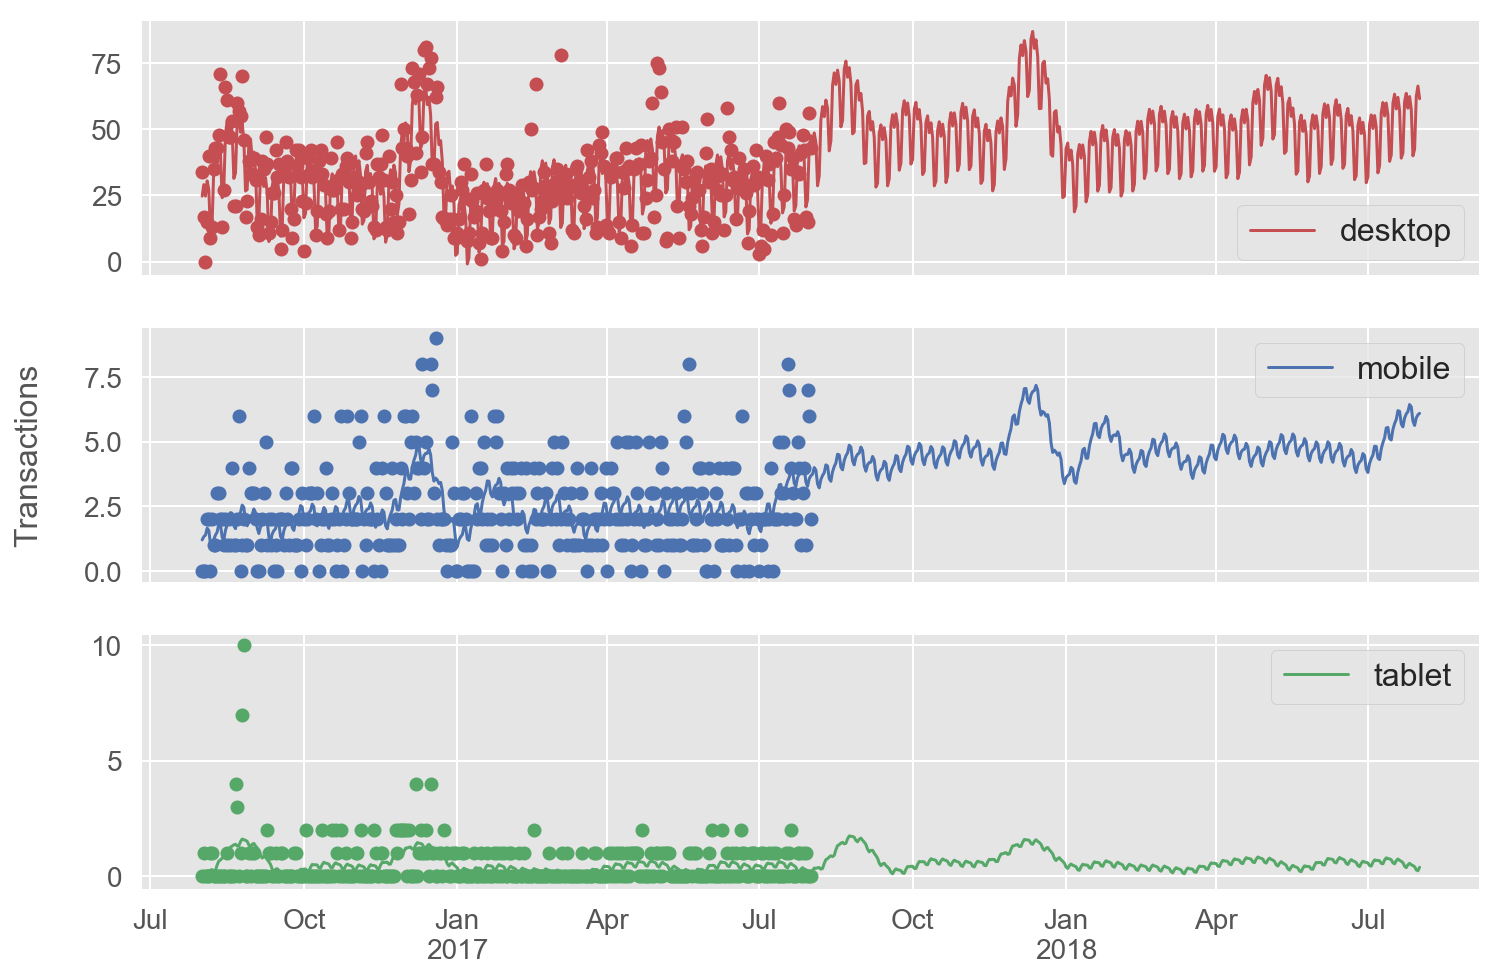

Saving figure to ../../results/figures/sales_forecast_deviceCategory=desktop_transactions_trends.png


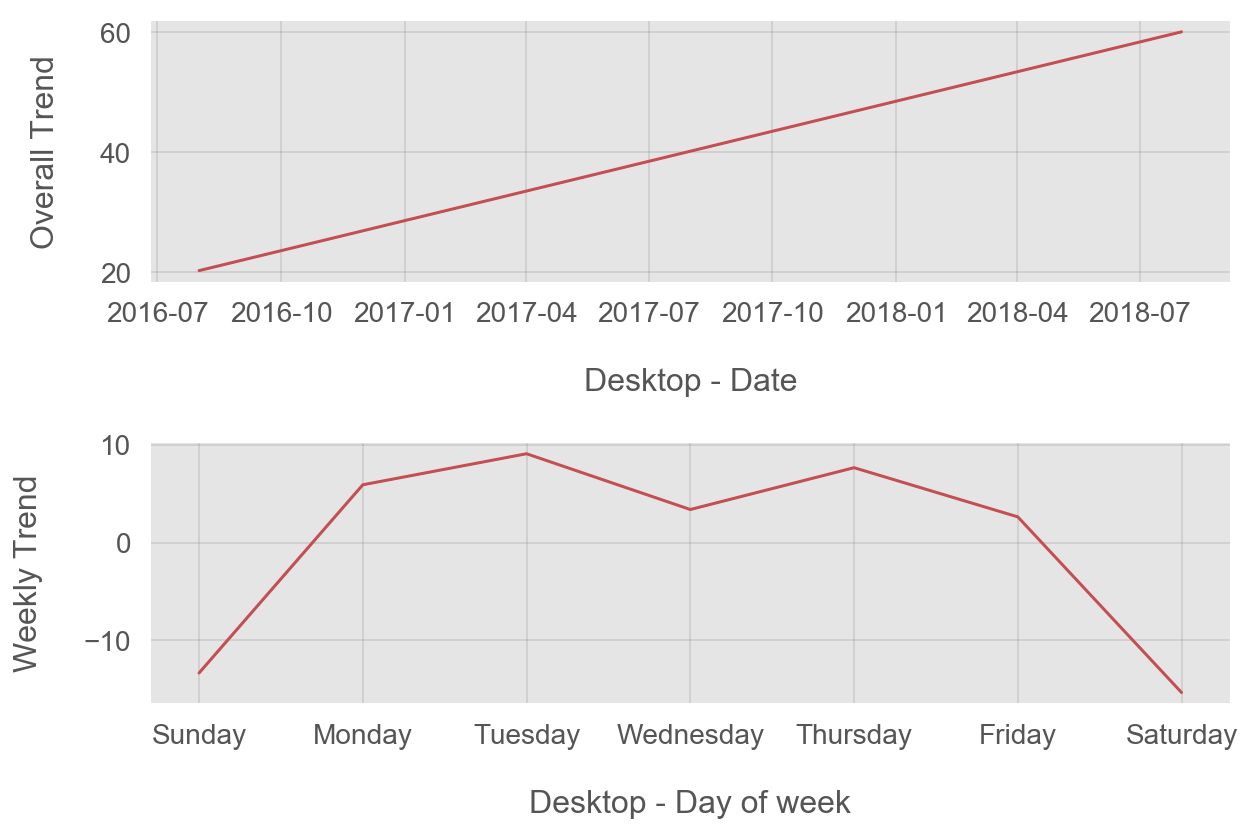

Saving figure to ../../results/figures/sales_forecast_deviceCategory=mobile_transactions_trends.png


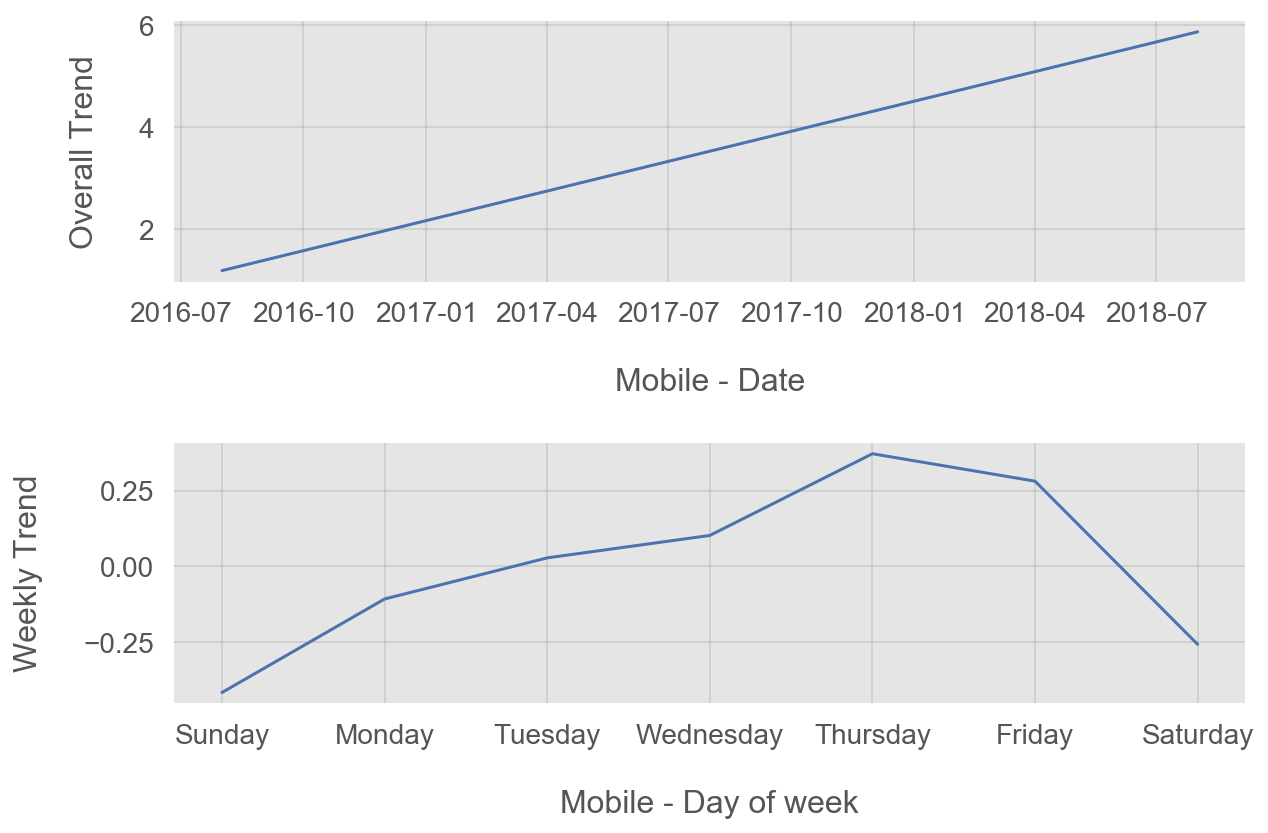

Saving figure to ../../results/figures/sales_forecast_deviceCategory=tablet_transactions_trends.png


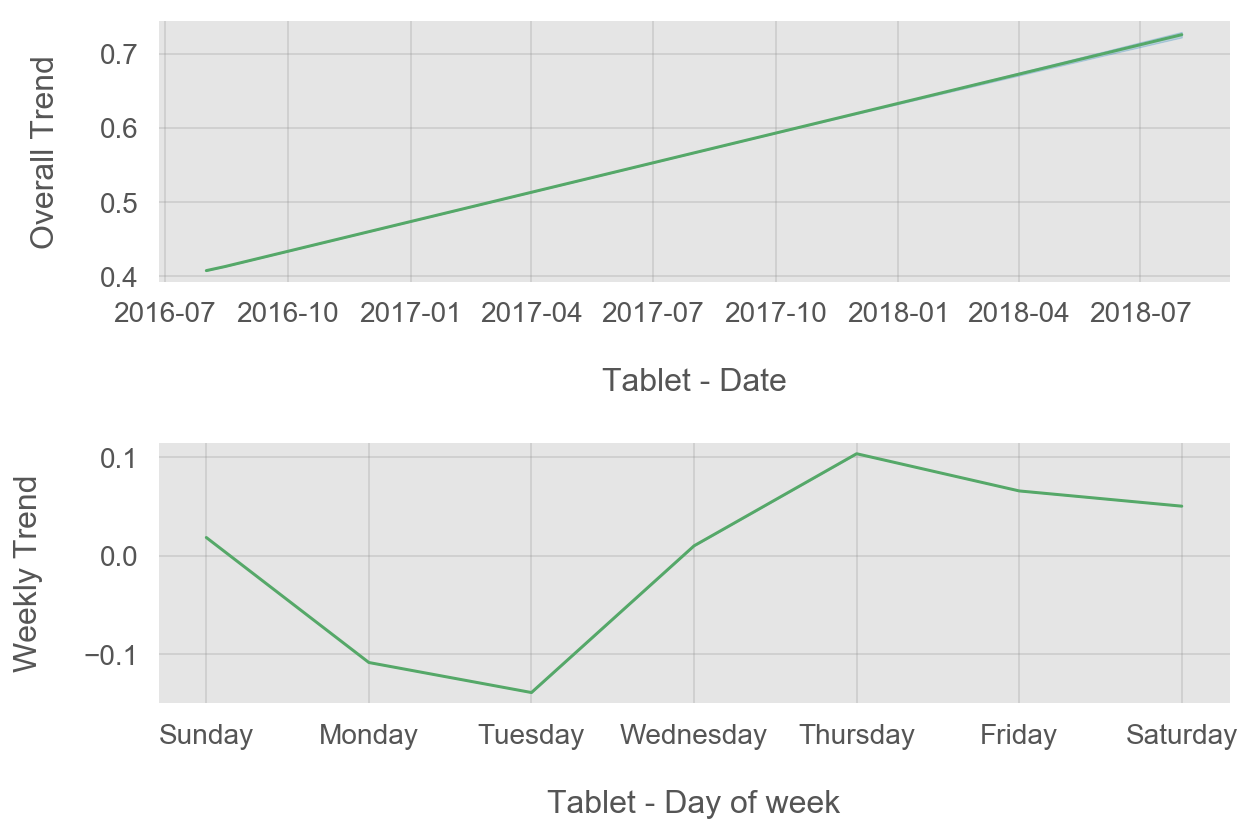

In [330]:
segment_forecast_daily(df, 'deviceCategory')

Cool! We can see distinct trends for day of week on mobile VS desktop.

Saving figure to ../../results/figures/sales_forecast_source_transactions.png


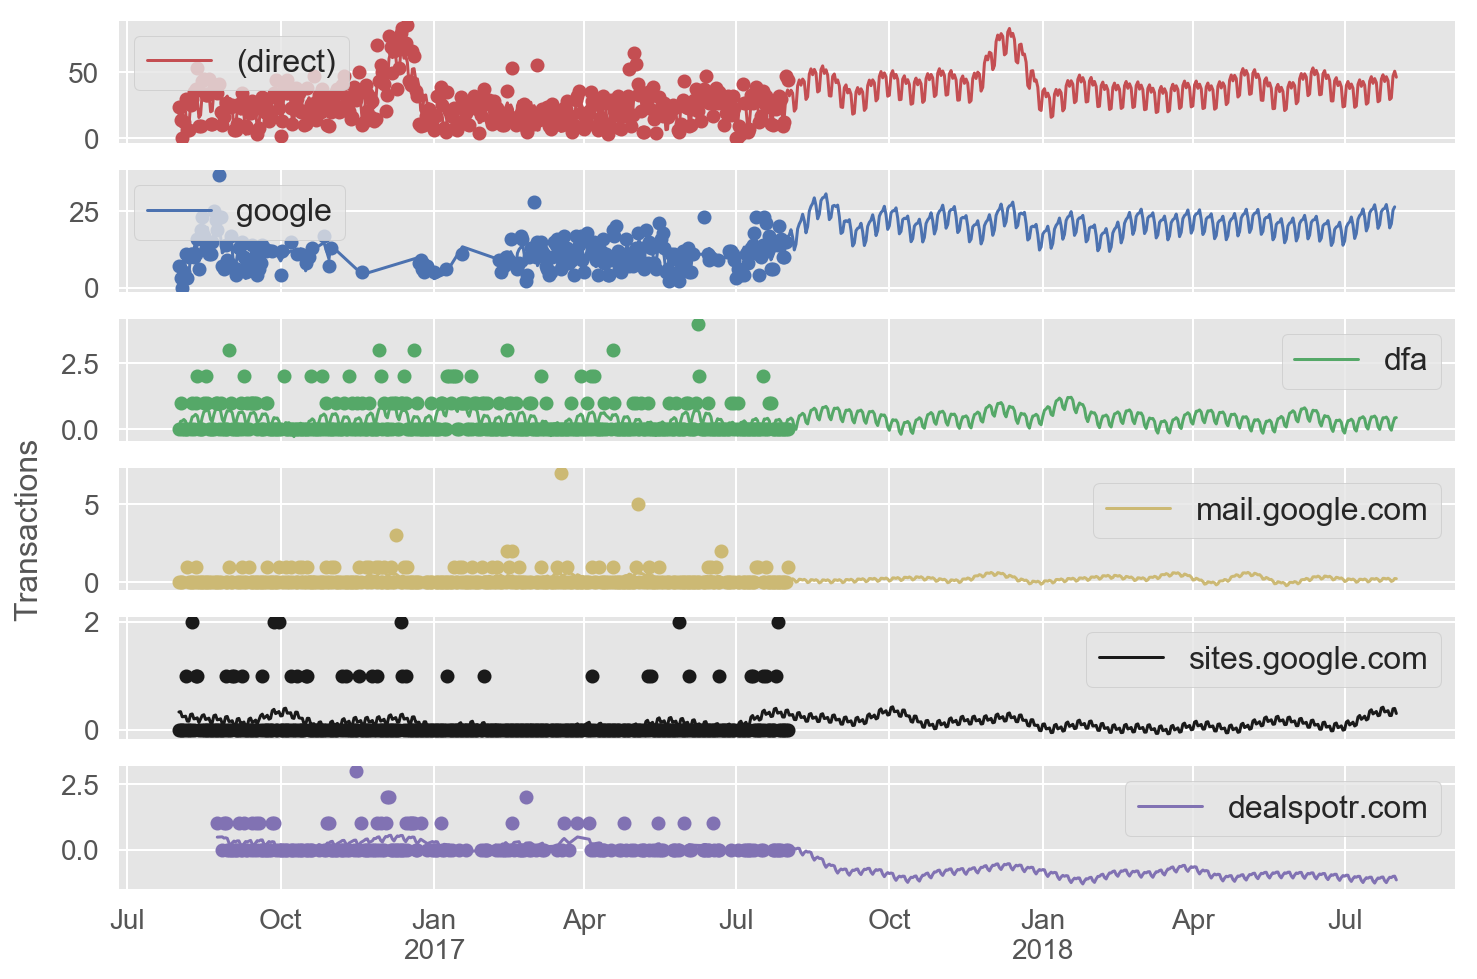

Saving figure to ../../results/figures/sales_forecast_source=(direct)_transactions_trends.png


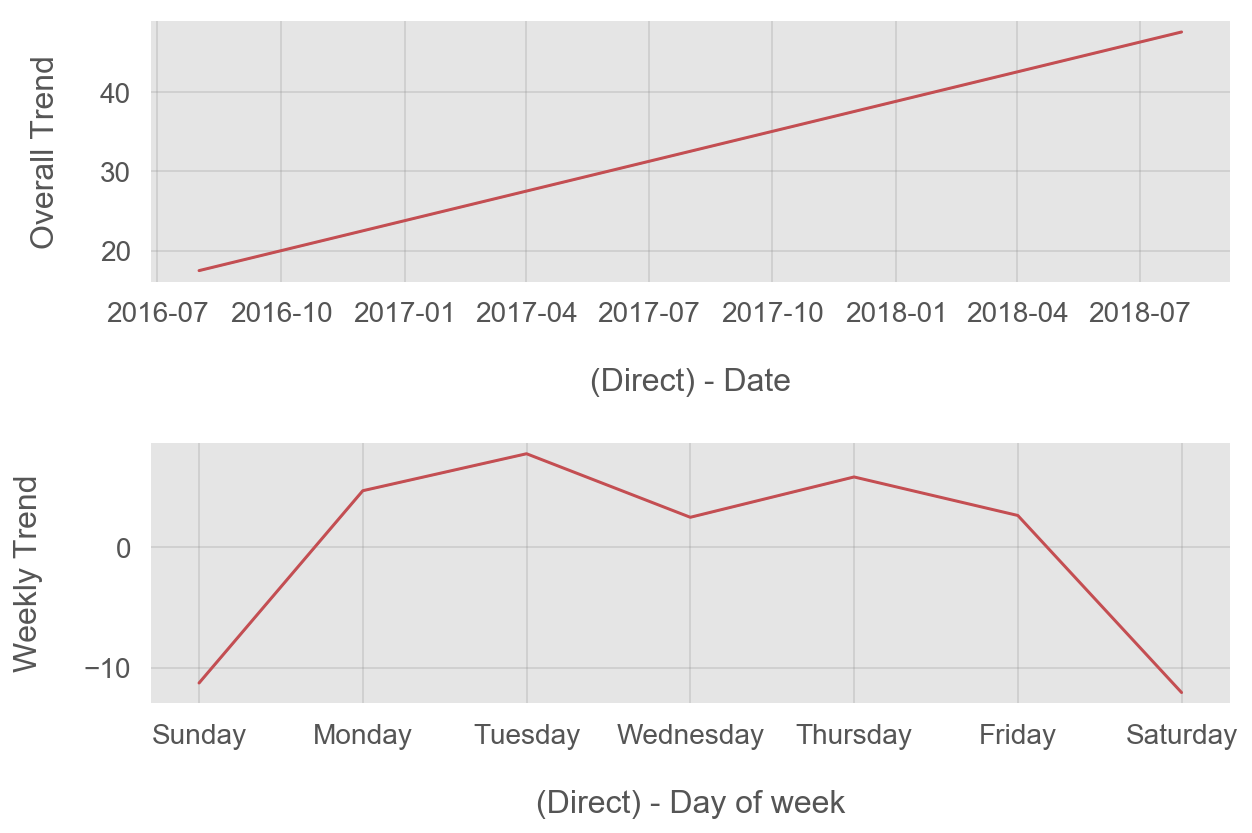

Saving figure to ../../results/figures/sales_forecast_source=google_transactions_trends.png


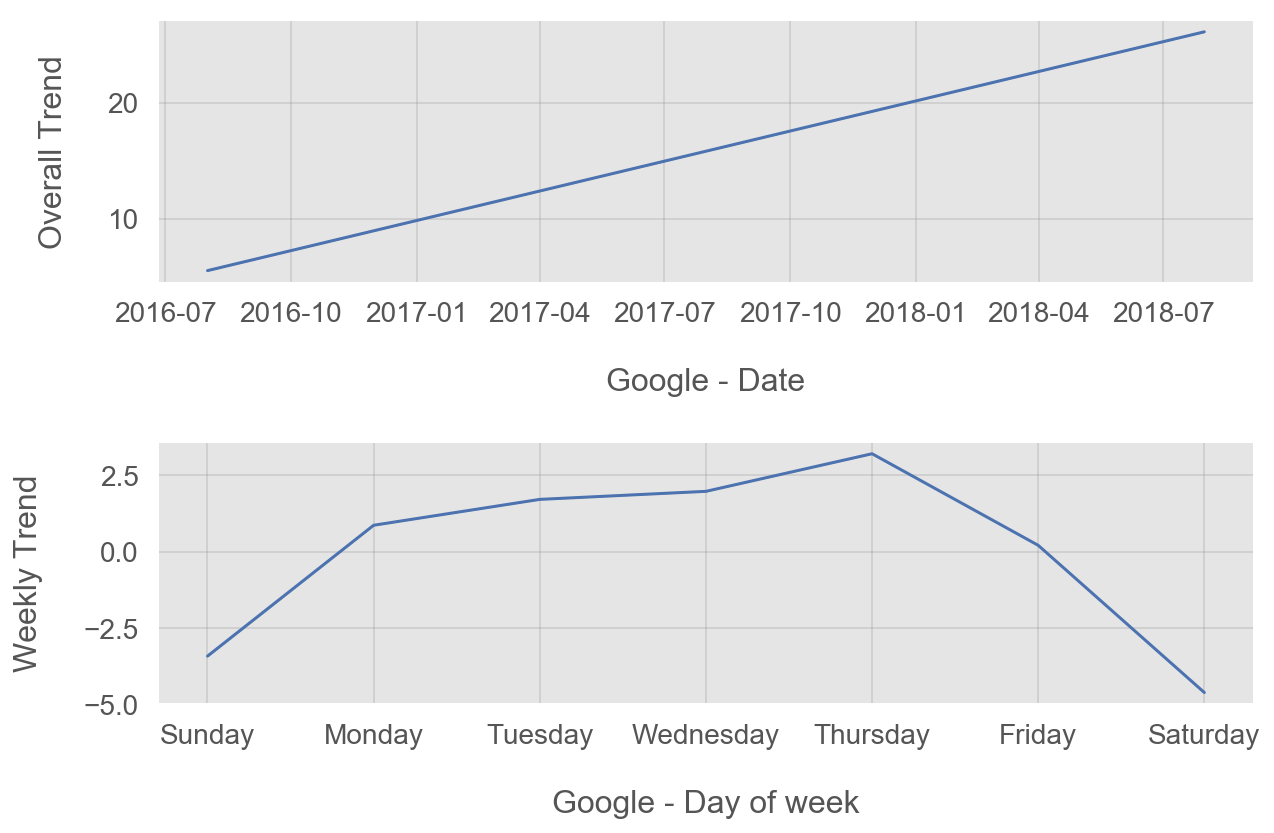

Saving figure to ../../results/figures/sales_forecast_source=dfa_transactions_trends.png


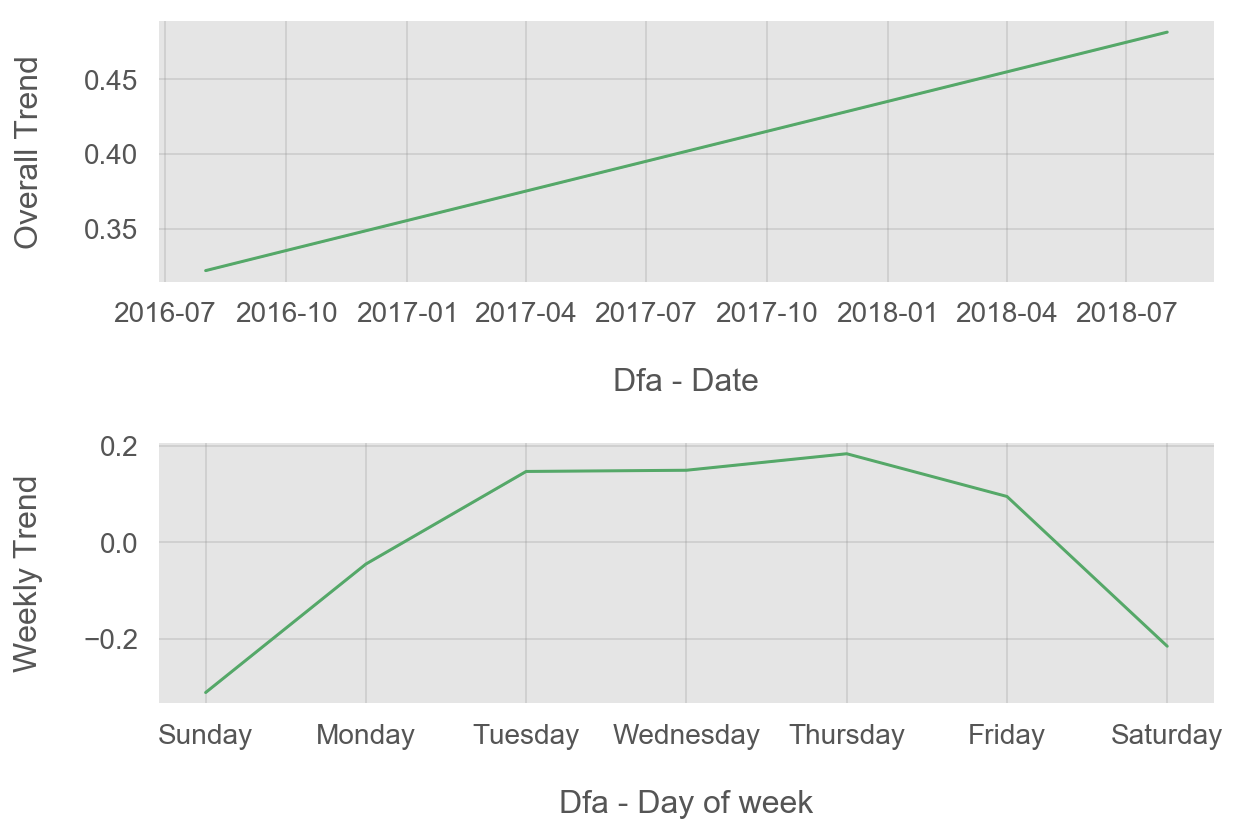

Saving figure to ../../results/figures/sales_forecast_source=mail.google.com_transactions_trends.png


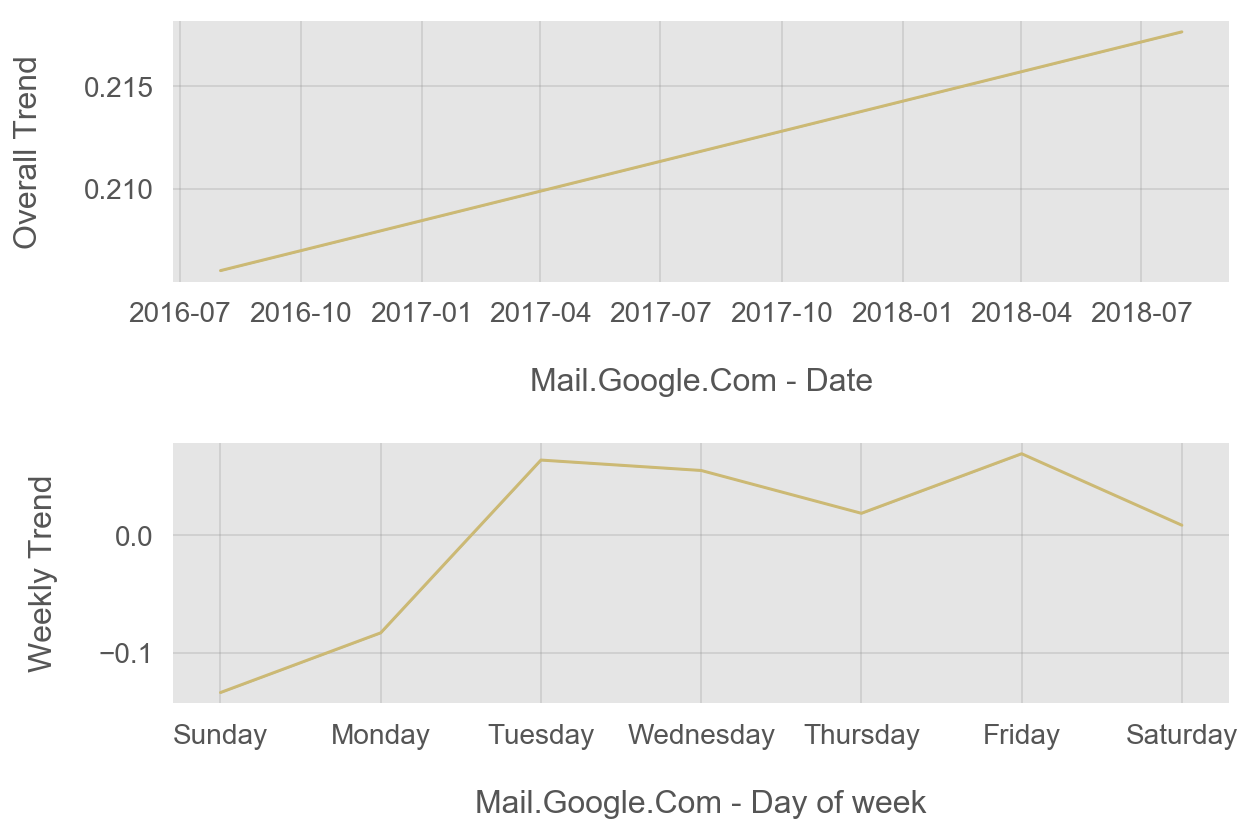

Saving figure to ../../results/figures/sales_forecast_source=sites.google.com_transactions_trends.png


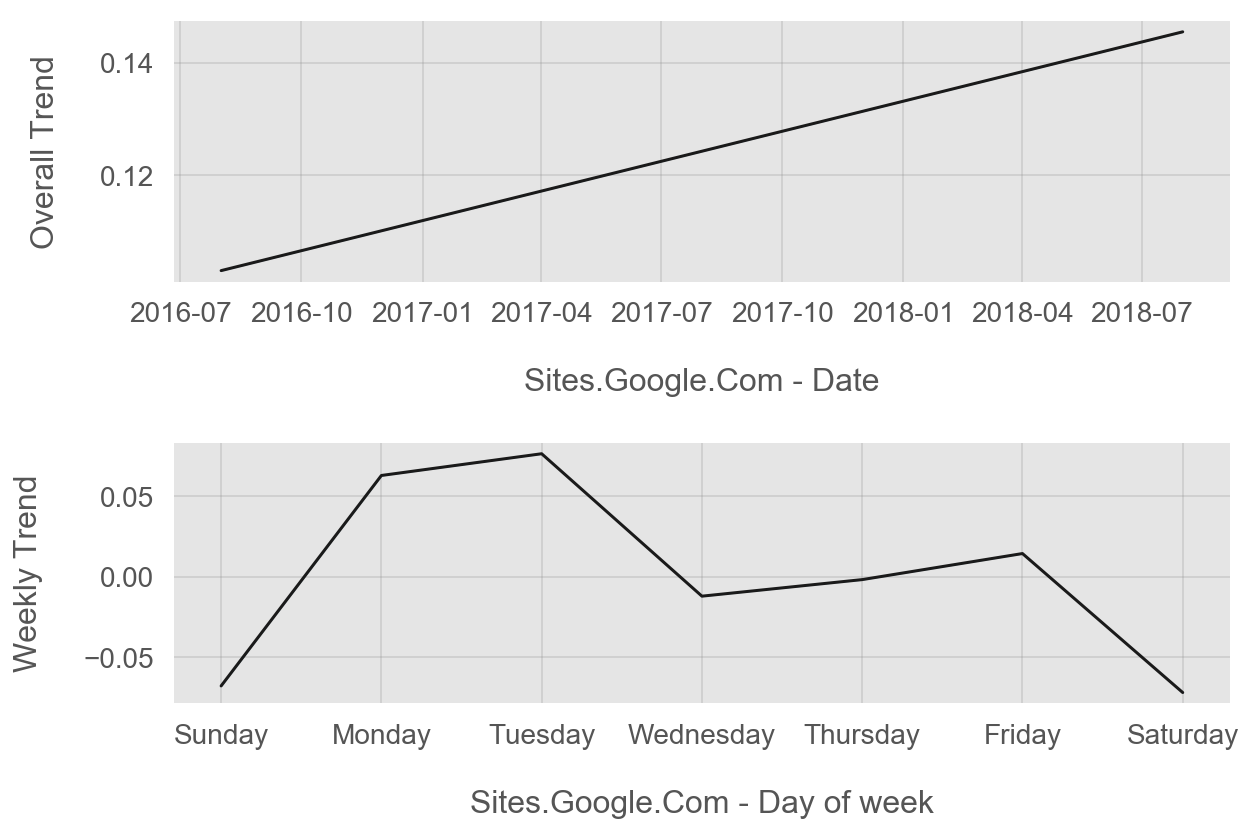

Saving figure to ../../results/figures/sales_forecast_source=dealspotr.com_transactions_trends.png


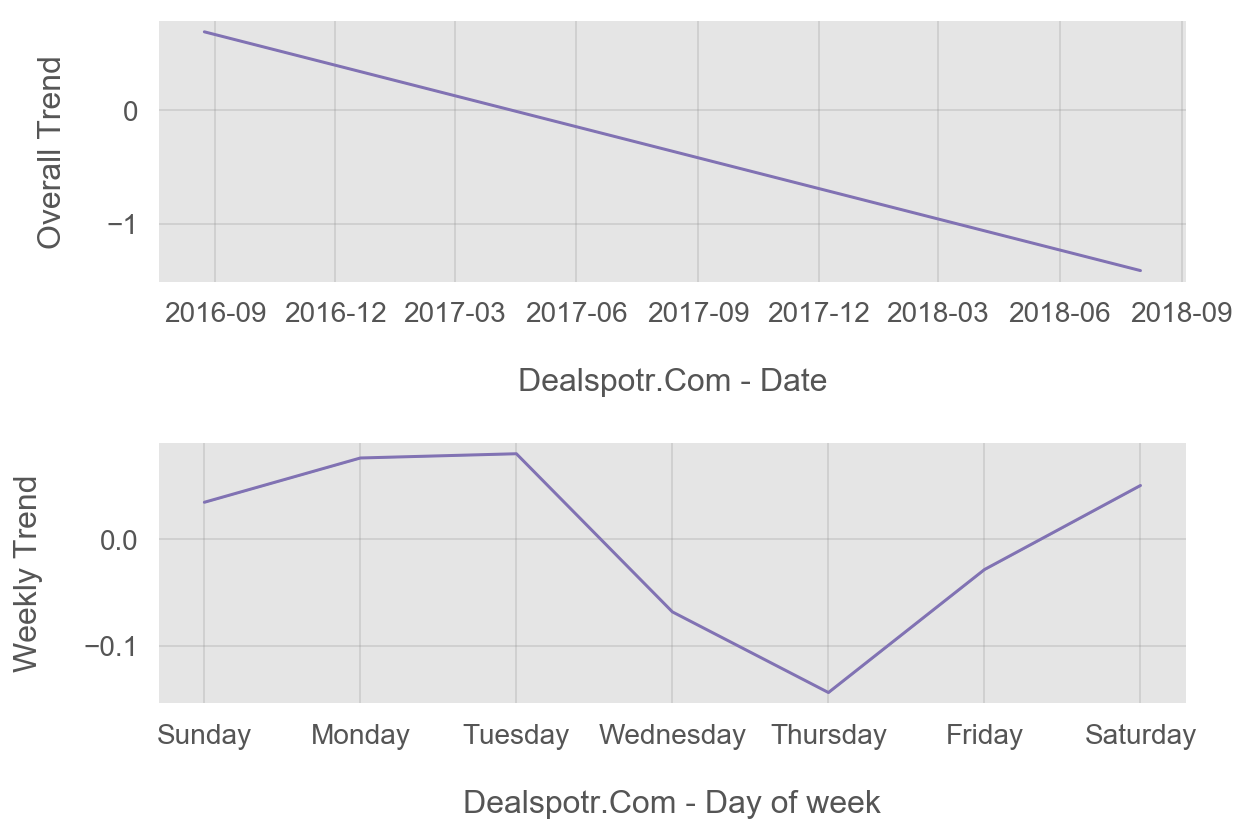

In [331]:
df_fltr = df[~(df.source.isin(['not available in demo dataset', '(not set)']))]
segment_forecast_daily(df_fltr, 'source')

Saving figure to ../../results/figures/sales_forecast_country_transactions.png


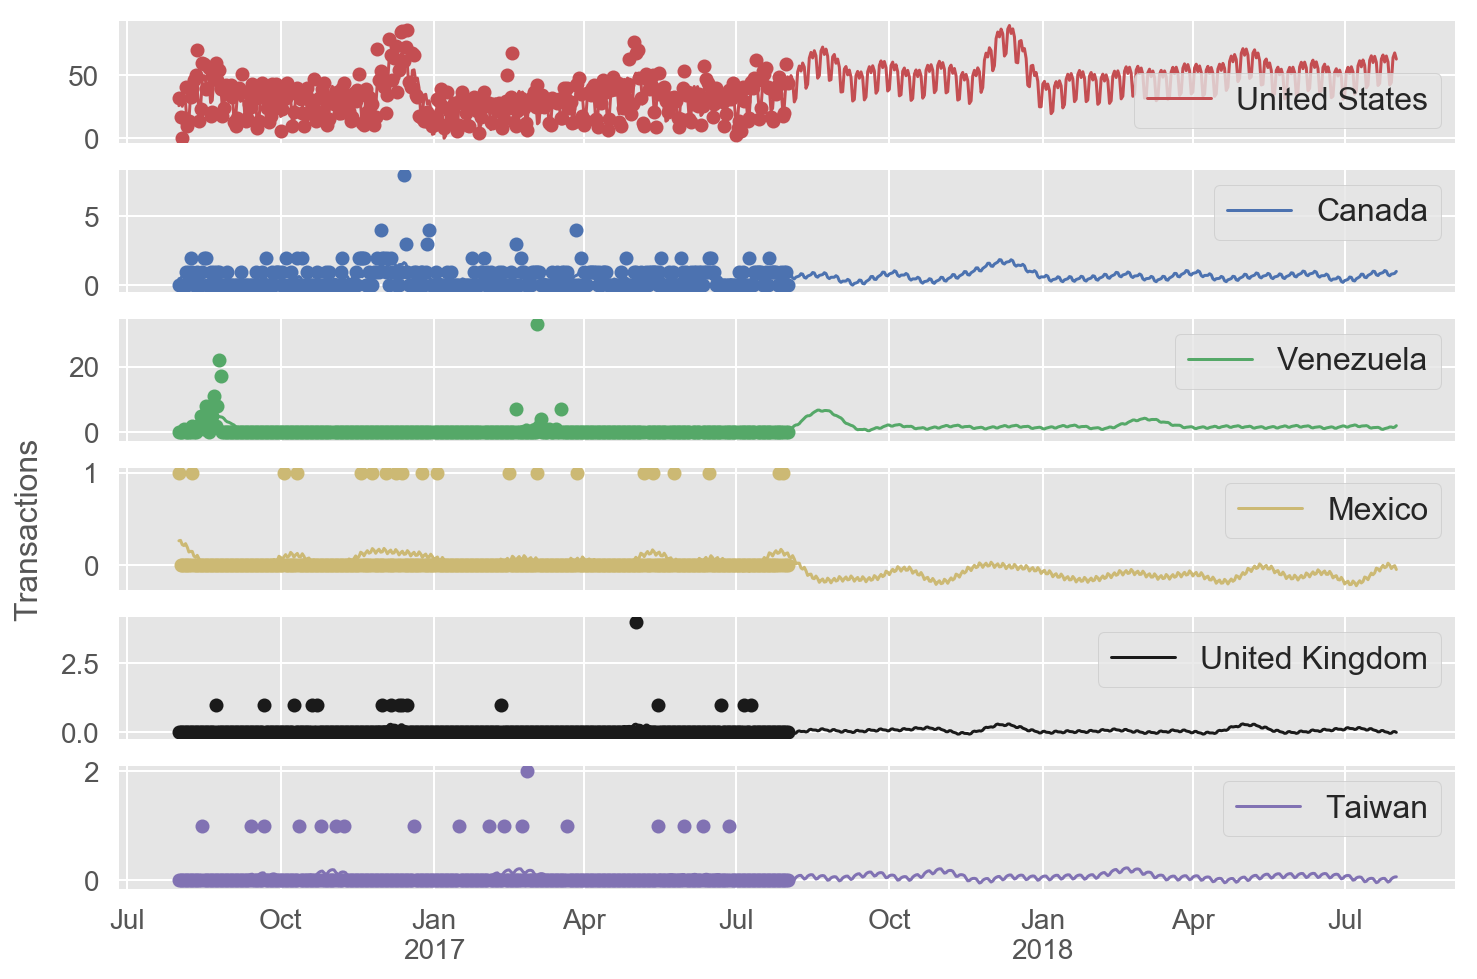

Saving figure to ../../results/figures/sales_forecast_country=United-States_transactions_trends.png


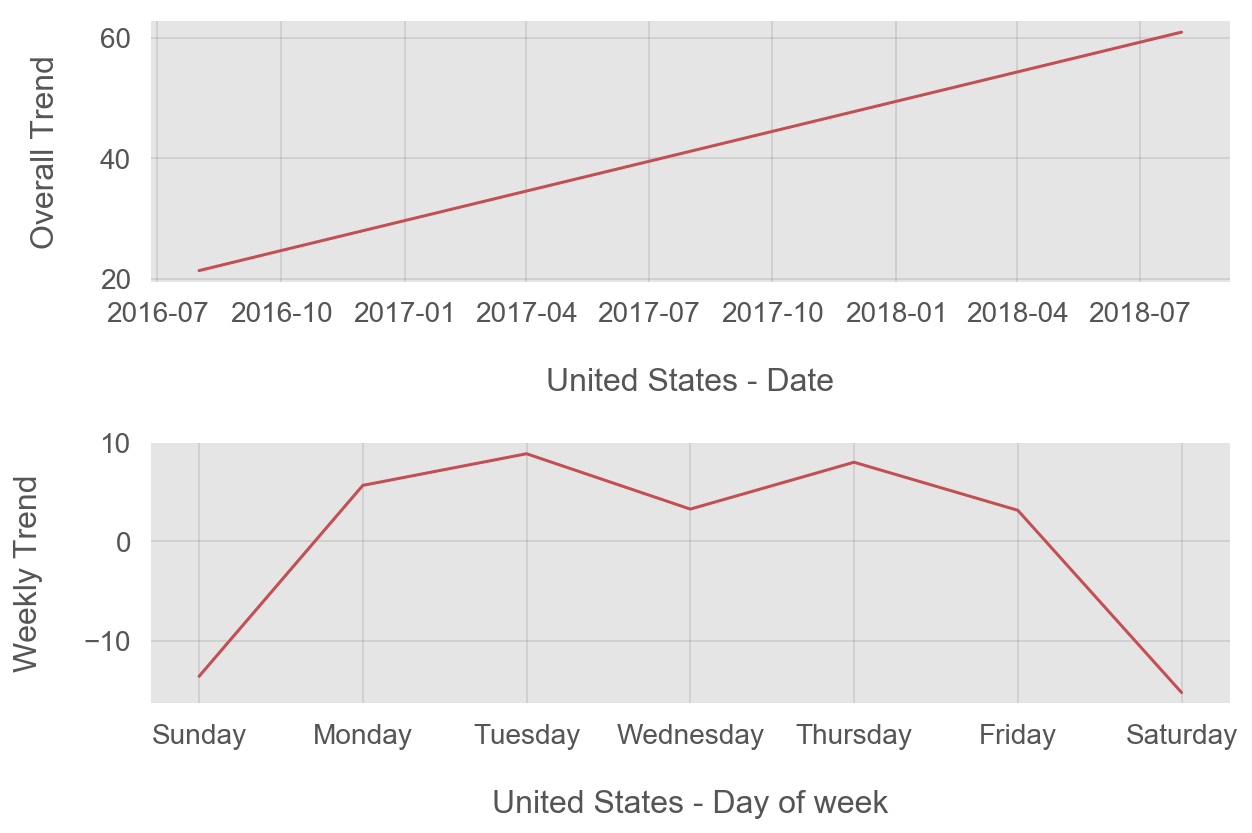

Saving figure to ../../results/figures/sales_forecast_country=Canada_transactions_trends.png


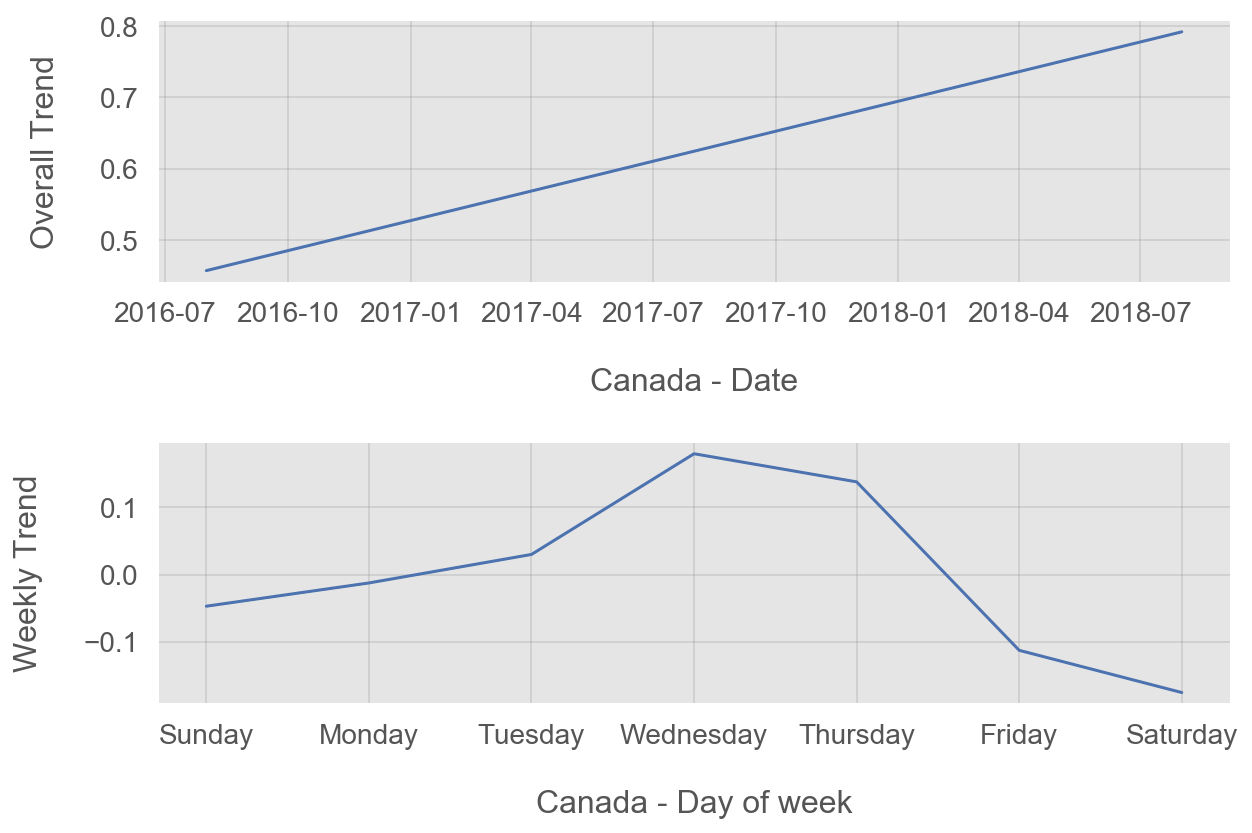

Saving figure to ../../results/figures/sales_forecast_country=Venezuela_transactions_trends.png


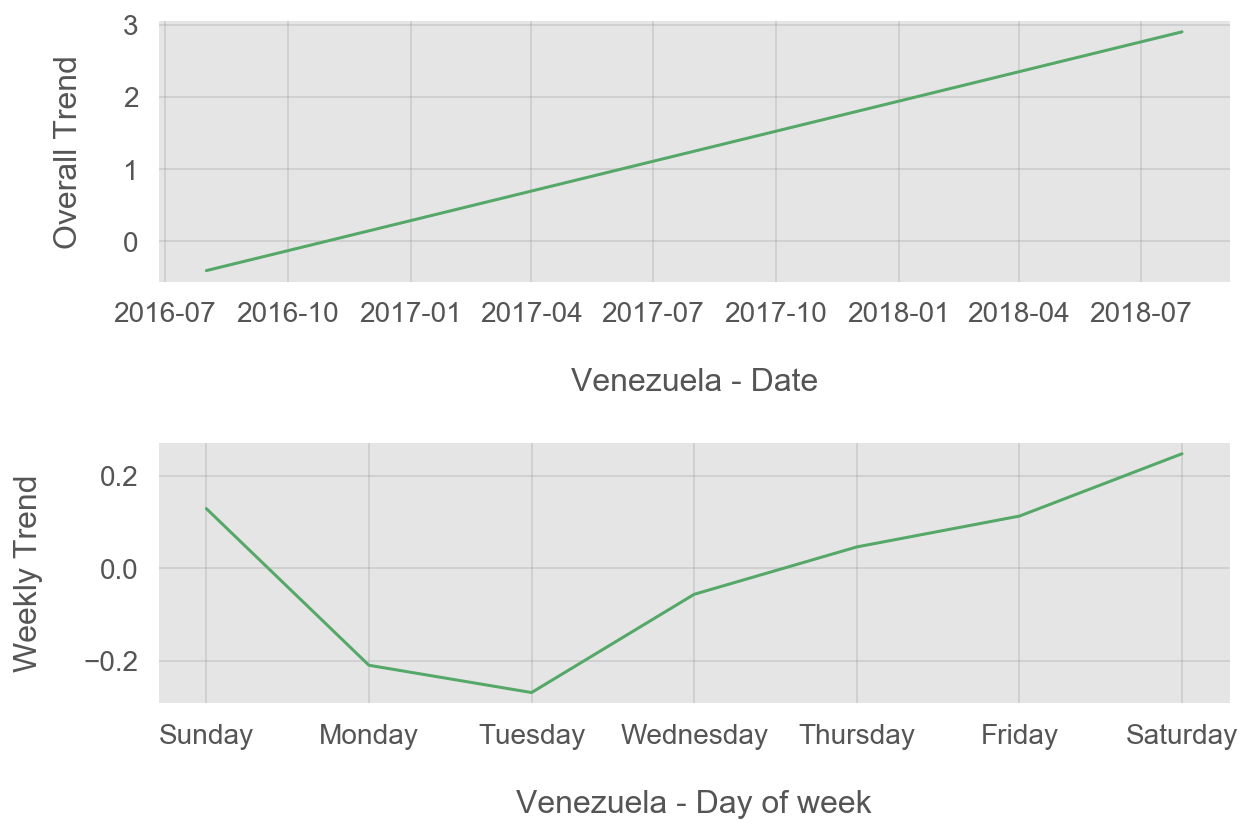

Saving figure to ../../results/figures/sales_forecast_country=Mexico_transactions_trends.png


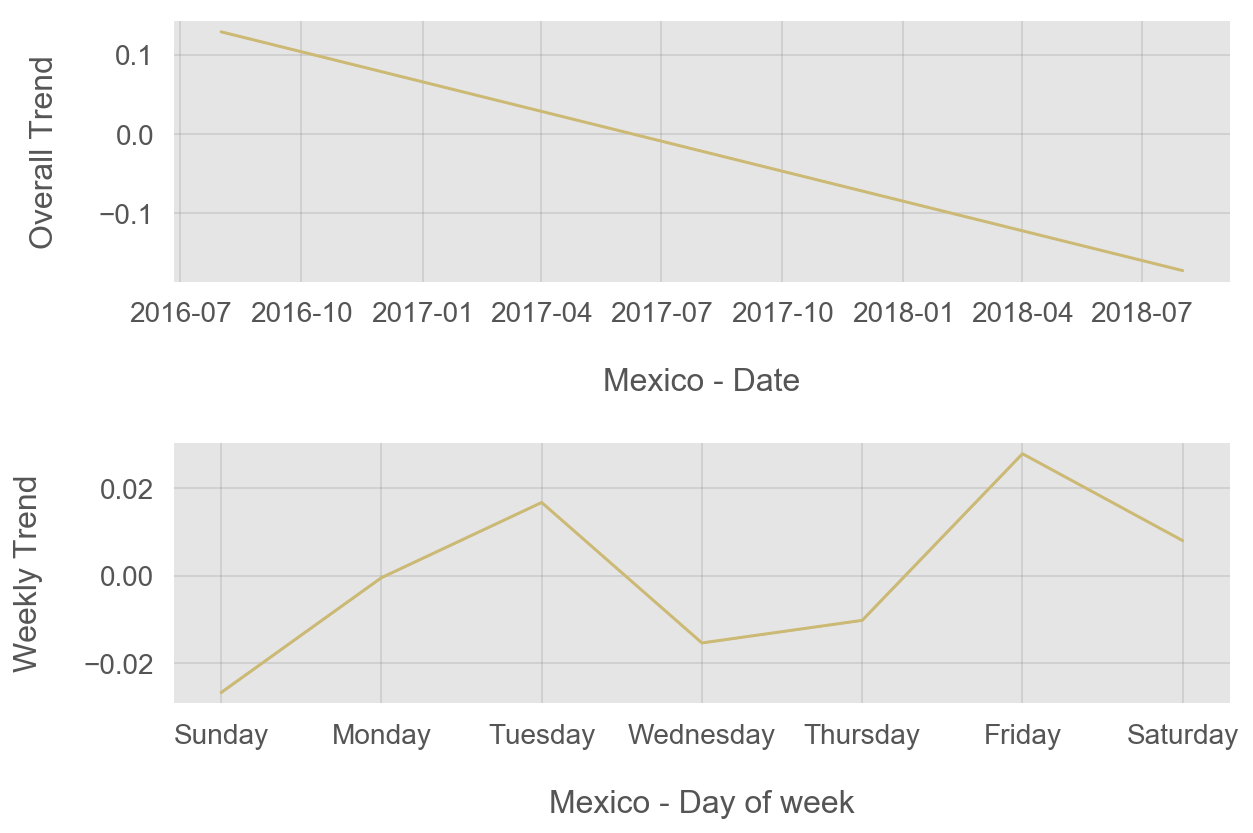

Saving figure to ../../results/figures/sales_forecast_country=United-Kingdom_transactions_trends.png


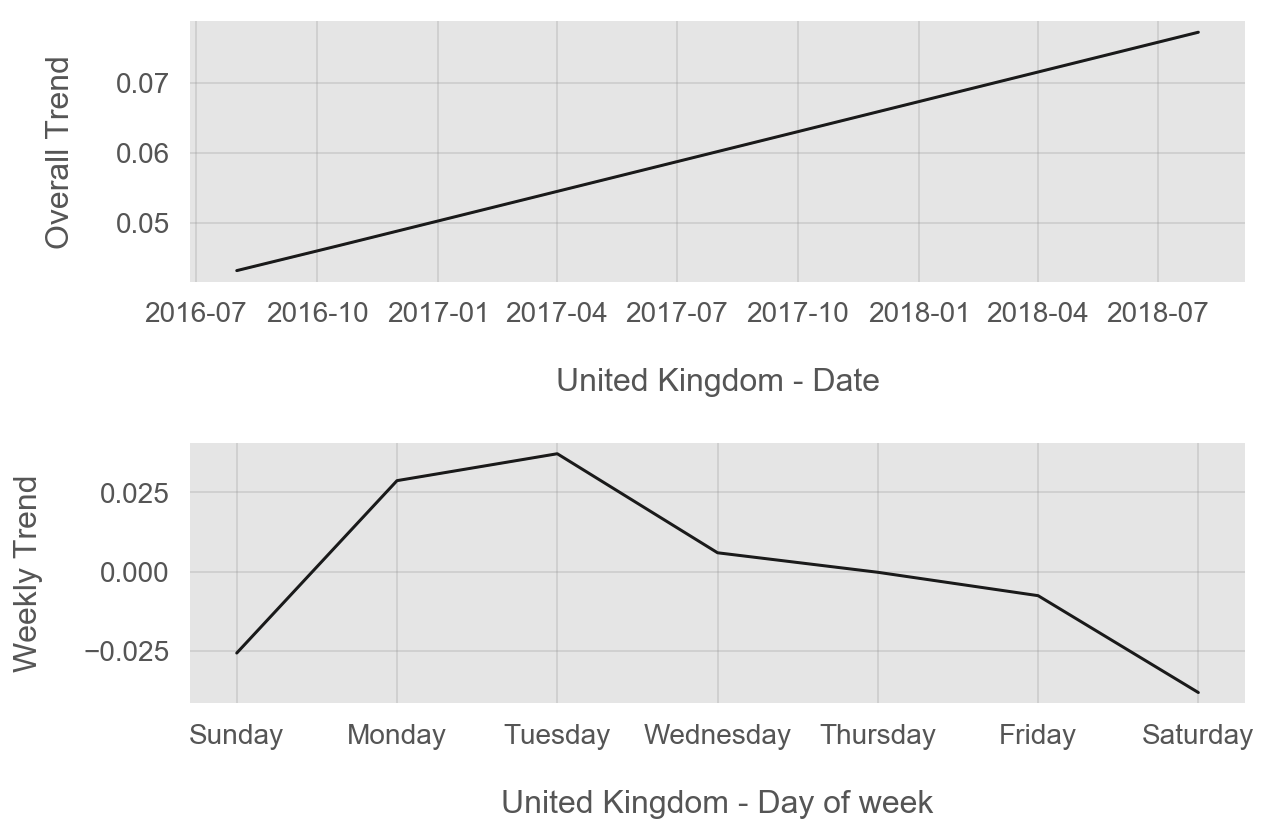

Saving figure to ../../results/figures/sales_forecast_country=Taiwan_transactions_trends.png


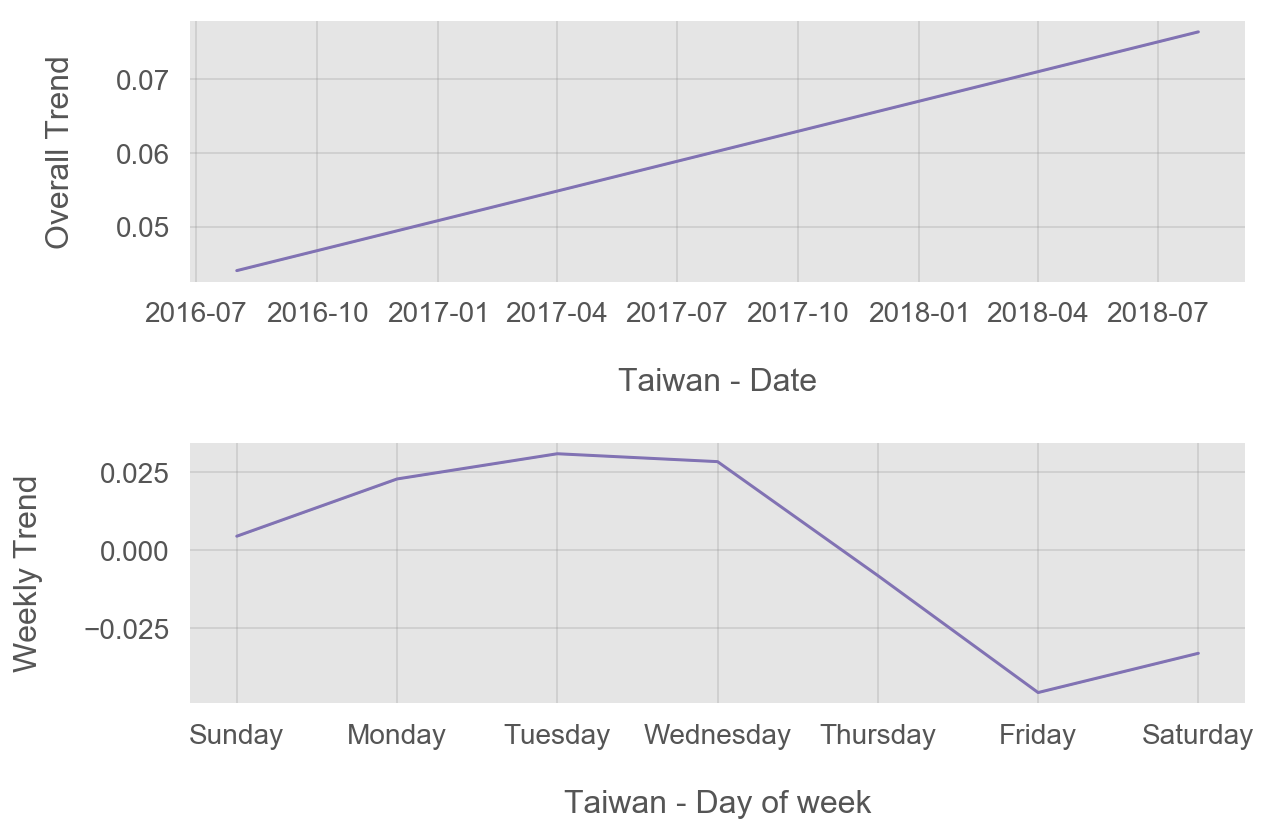

In [332]:
df_fltr = df[~(df.country.isin(['not available in demo dataset', '(not set)']))]
segment_forecast_daily(df_fltr, 'country')

Saving figure to ../../results/figures/sales_forecast_region_transactions.png


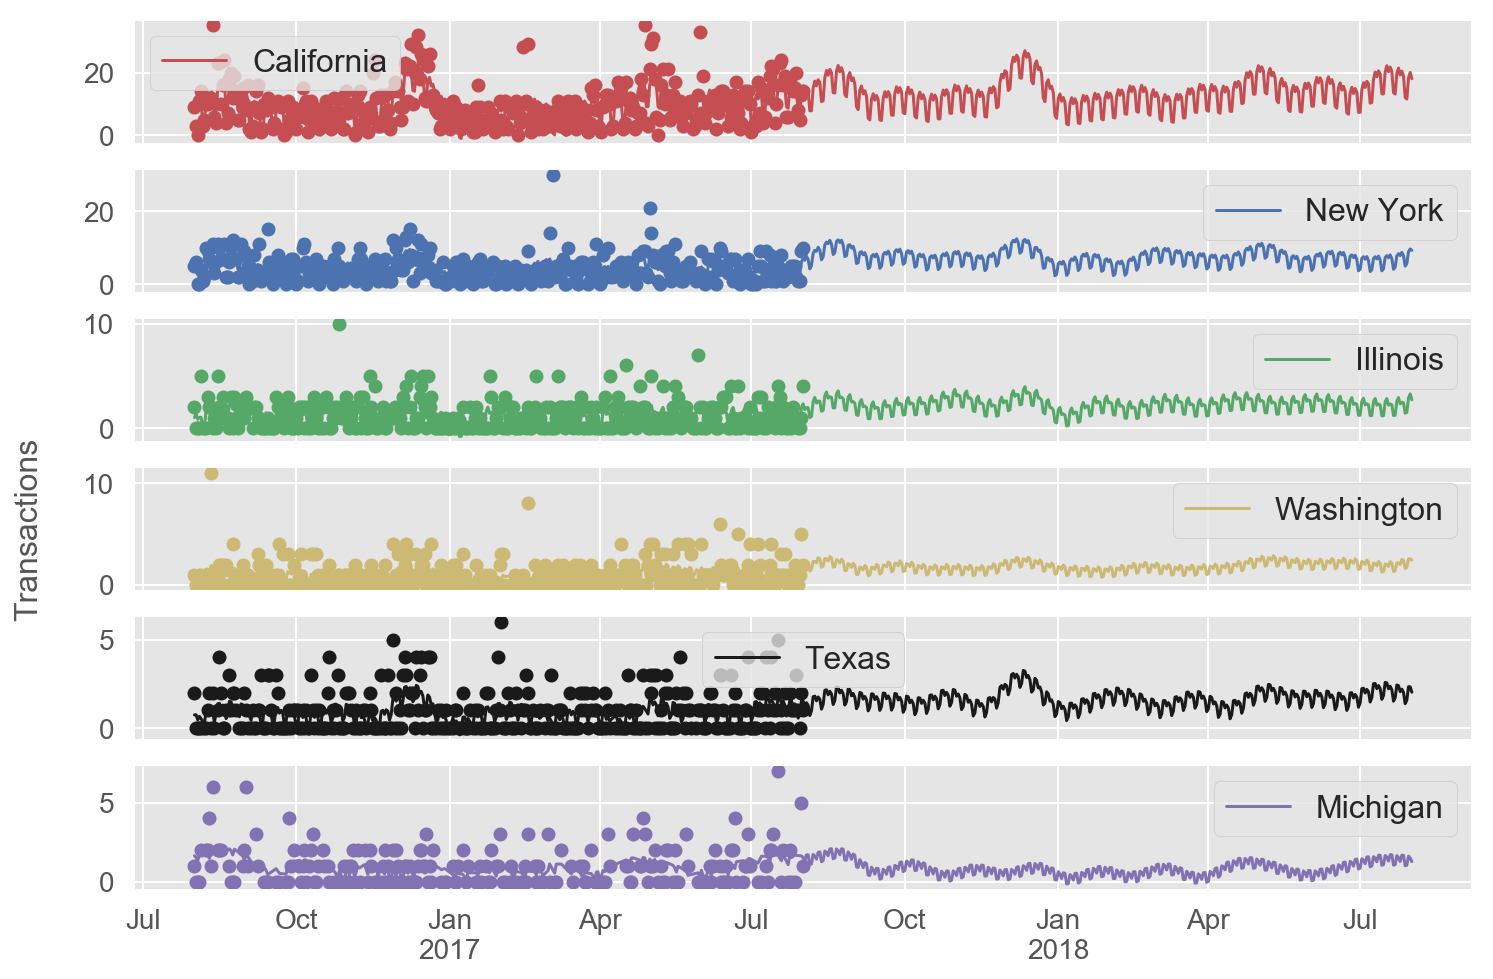

Saving figure to ../../results/figures/sales_forecast_region=California_transactions_trends.png


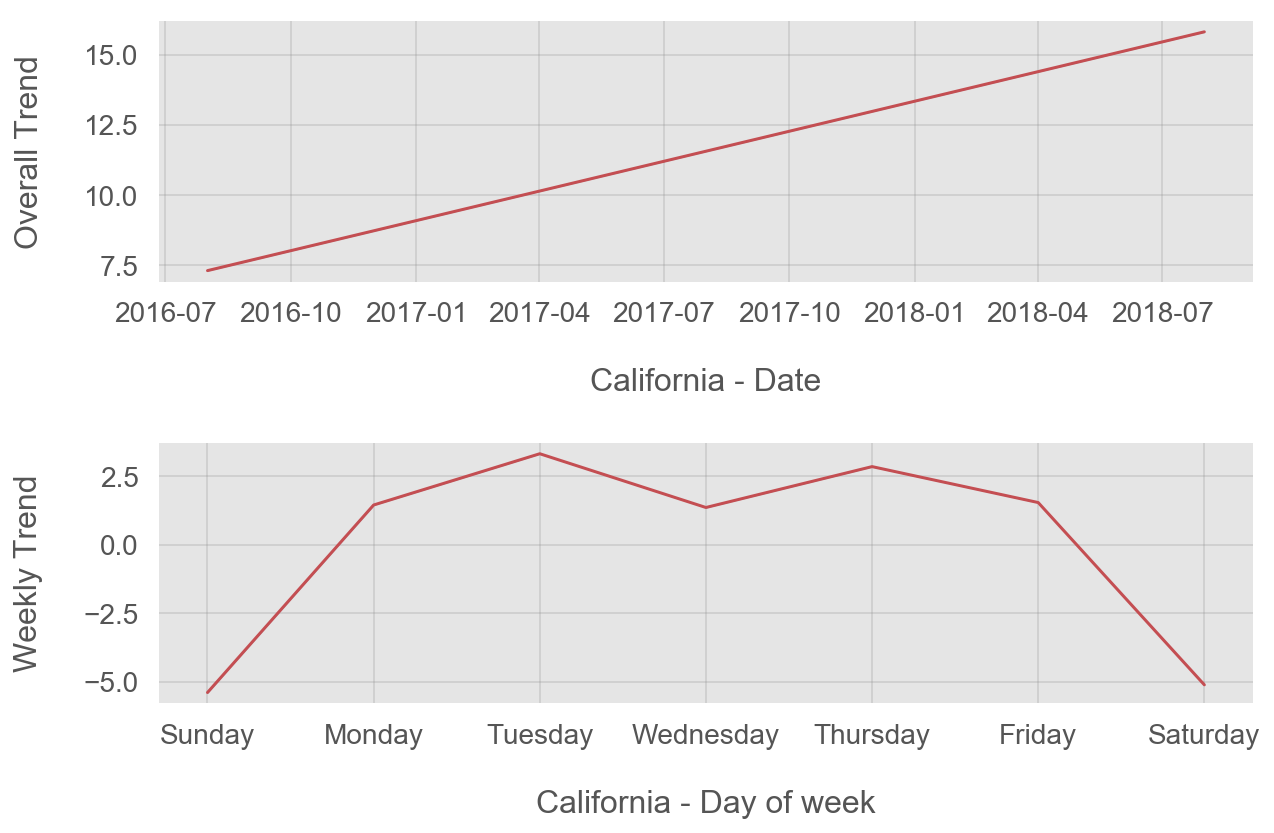

Saving figure to ../../results/figures/sales_forecast_region=New-York_transactions_trends.png


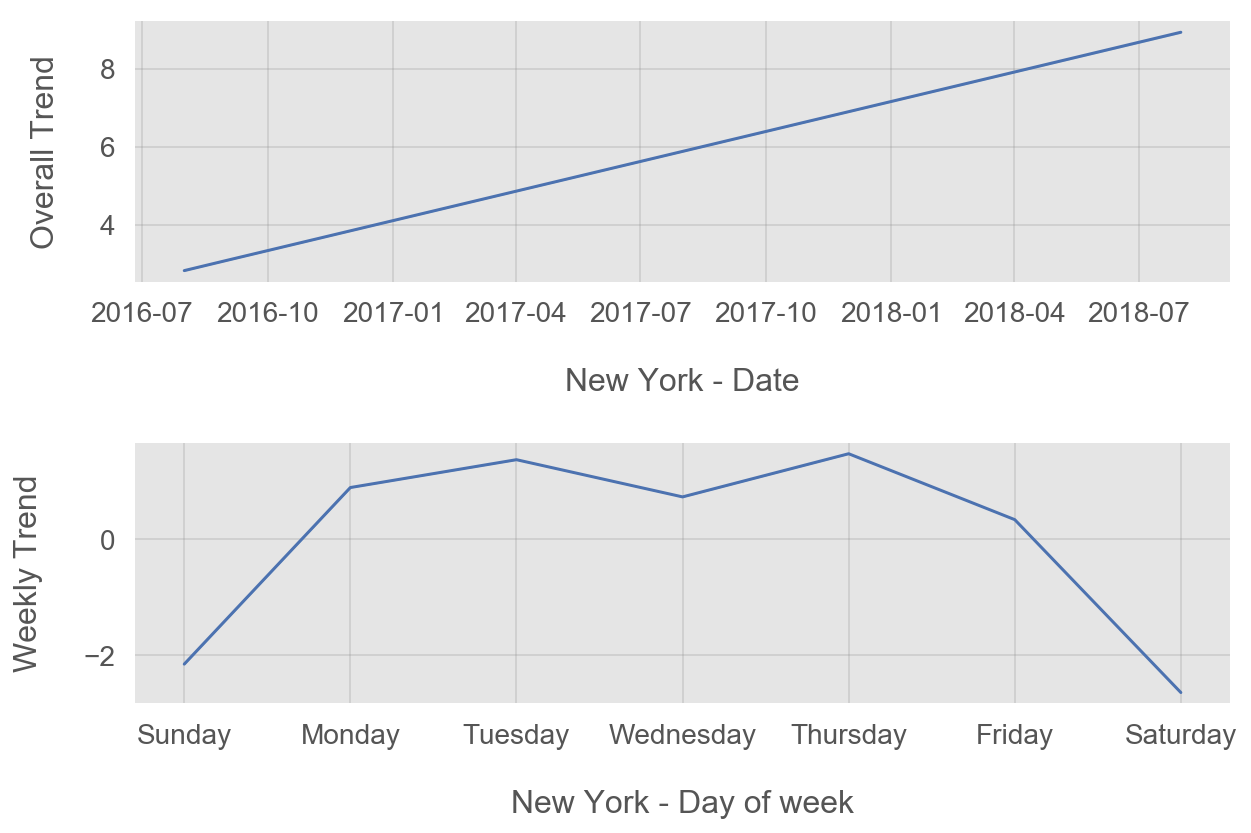

Saving figure to ../../results/figures/sales_forecast_region=Illinois_transactions_trends.png


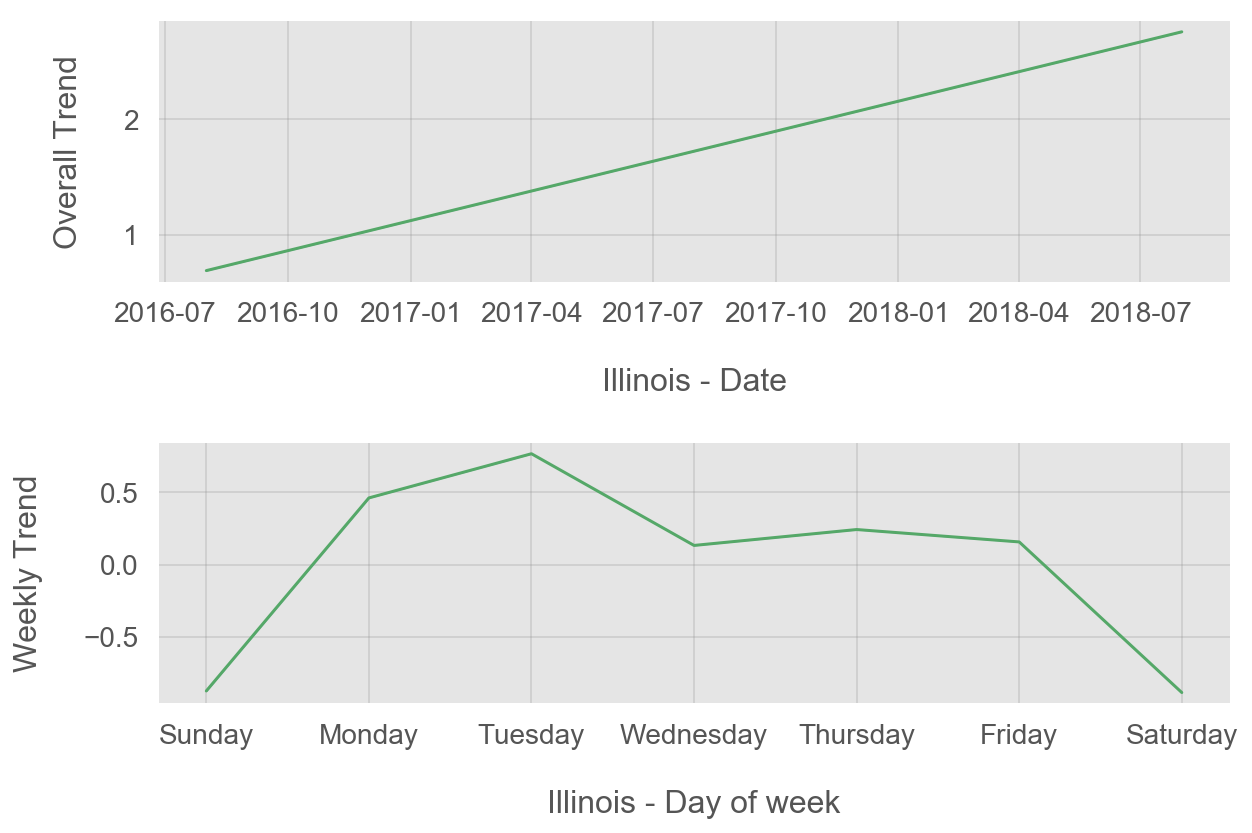

Saving figure to ../../results/figures/sales_forecast_region=Washington_transactions_trends.png


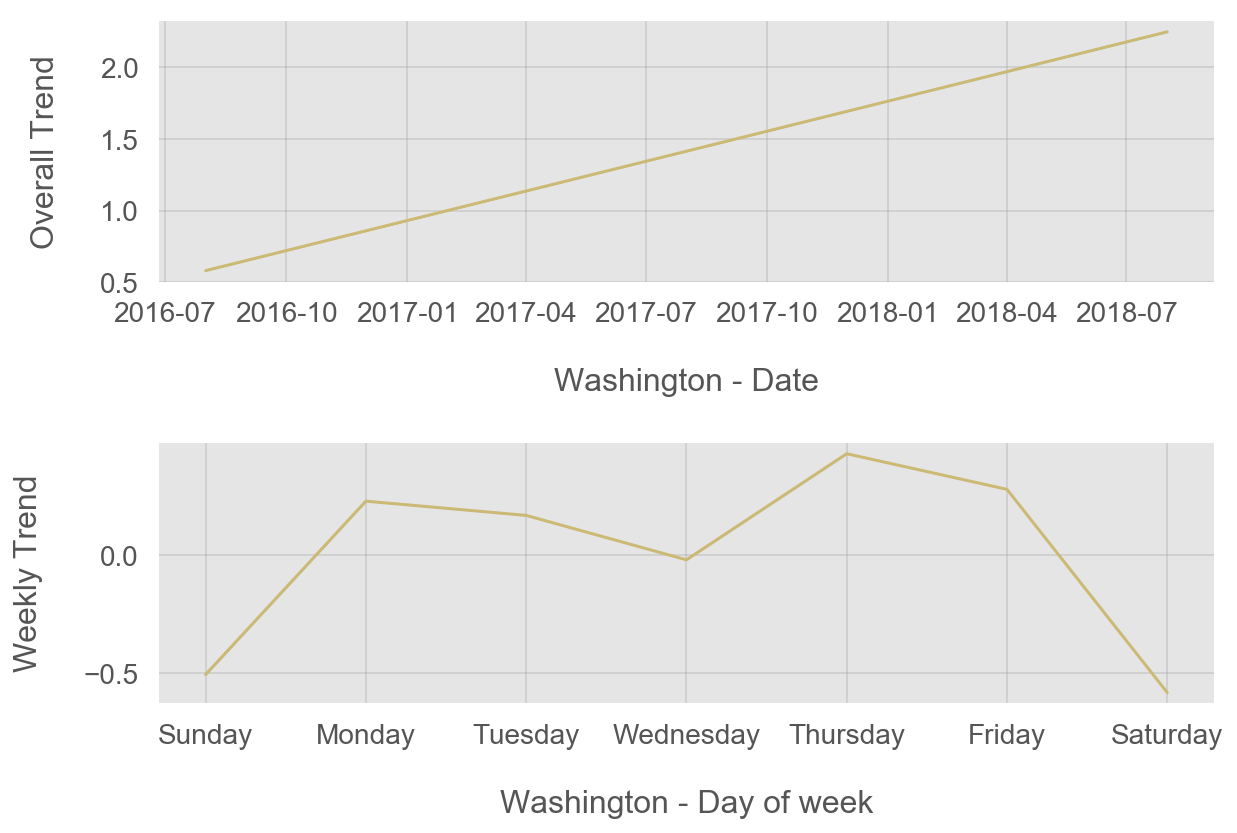

Saving figure to ../../results/figures/sales_forecast_region=Texas_transactions_trends.png


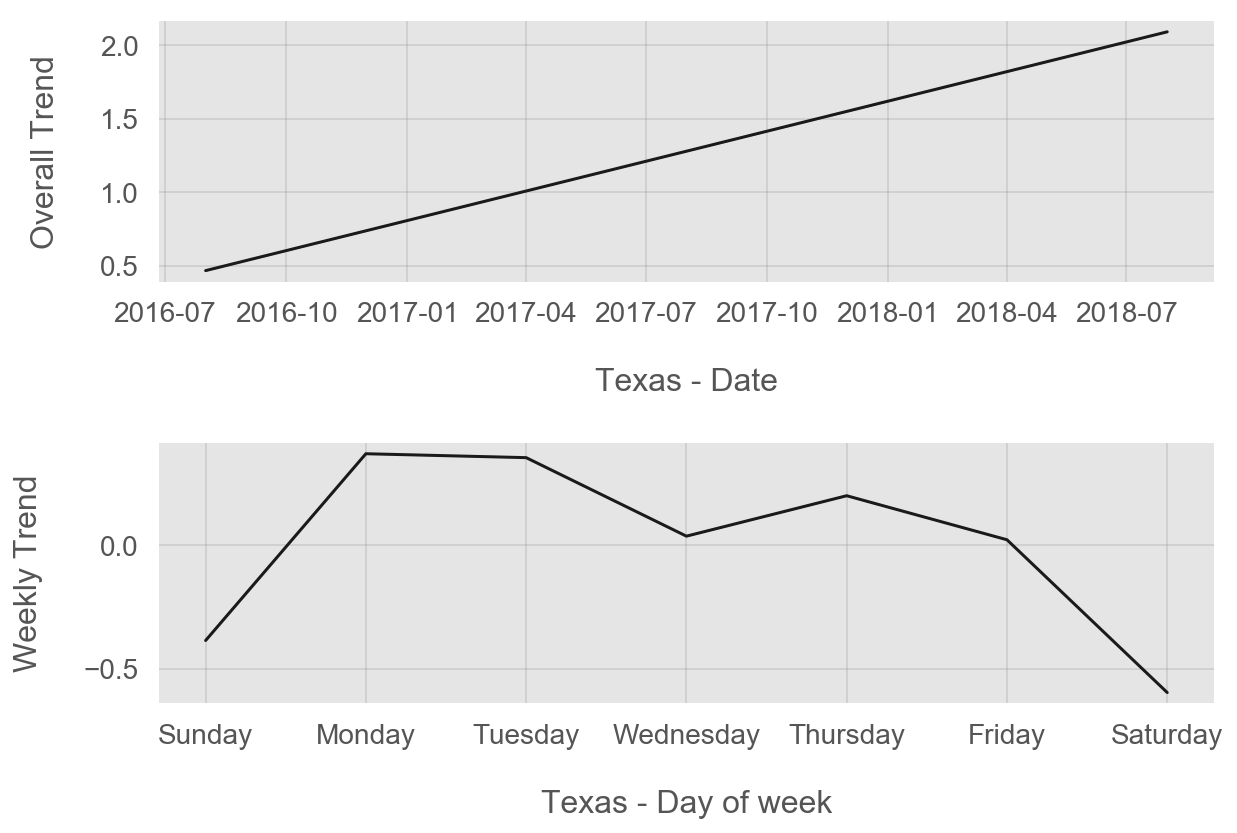

Saving figure to ../../results/figures/sales_forecast_region=Michigan_transactions_trends.png


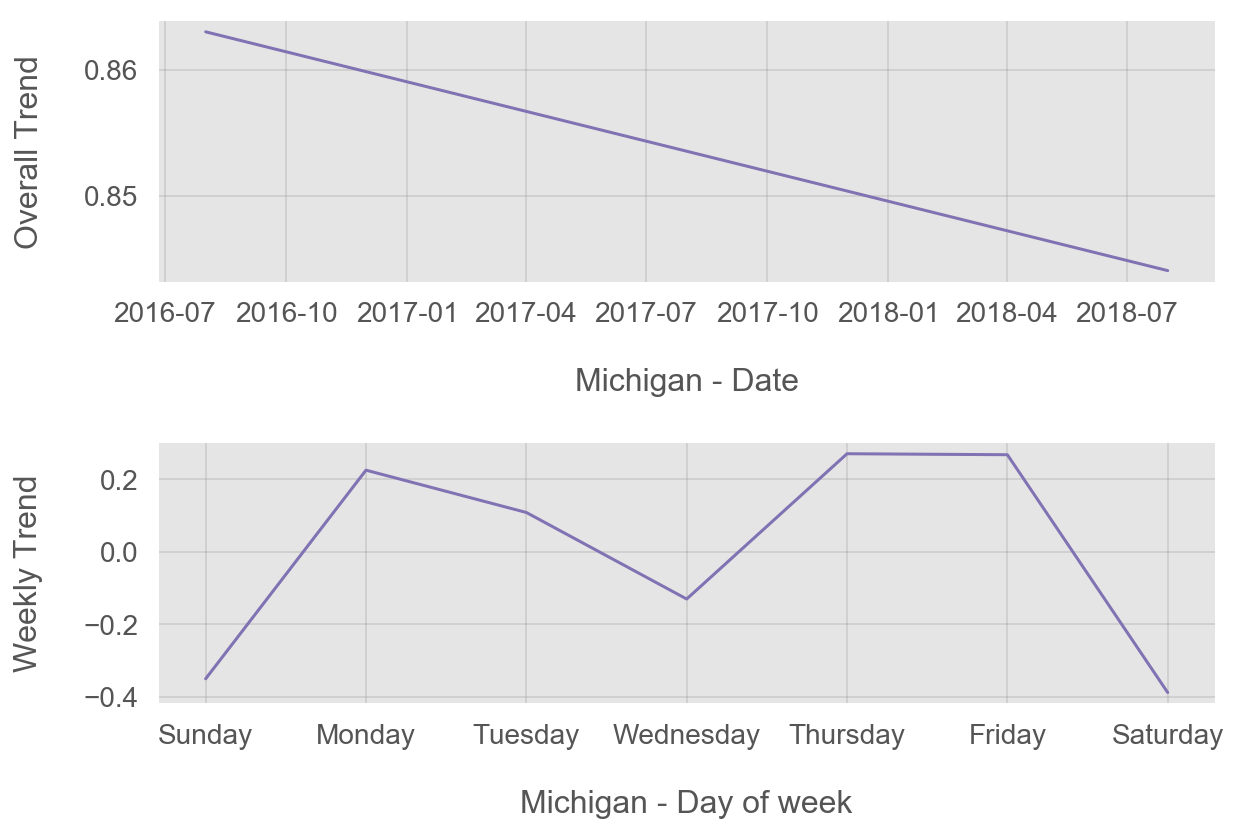

In [333]:
df_fltr = df[~(df.region.isin(['not available in demo dataset', '(not set)']))]
segment_forecast_daily(df_fltr, 'region')

## Forecasting by product

### Read from bigquery

In [ ]:
%%time
"""
Using bigquery
"""

def pull_daily_product_sales(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
        SELECT
            h.item.productName AS other_purchased_products,
            COUNT(h.item.productName) AS quantity
        FROM `bigquery-public-data.google_analytics_sample.{}`,
            UNNEST(hits) as h
        WHERE (
            fullVisitorId IN (
                SELECT fullVisitorId
                FROM `bigquery-public-data.google_analytics_sample.{}`,
                    UNNEST(hits) as h
                WHERE h.item.productName CONTAINS 'Product Item Name A'
                AND totals.transactions>=1
                GROUP BY fullVisitorId
            )
            AND h.item.productName IS NOT NULL
            AND h.item.productName != 'Product Item Name A'
        )
        GROUP BY other_purchased_products
        ORDER BY quantity DESC;
        '''.format(table.table_id, table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_product_results = pull_daily_product_sales()

In [ ]:
bq_product_results.head()

In [ ]:
df = bq_product_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

### Read from `jsonl` local

In [304]:
from typing import List, Tuple, Dict

In [305]:
%%time
"""
Using local jsonl
"""
ERRORS = []

def pull_daily_product_sales(
    verbose=False,
    raise_errors=False,
    test=False,
) -> Tuple[pd.DataFrame, dict]:
    if os.getenv('DATA_PATH') is None:
        raise ValueError('Please set environment variable DATA_PATH')

    dataset = sorted(glob.glob(os.path.join(os.getenv('DATA_PATH'), 'raw', '*.jsonl')))
    print('Loading from {}, etc...'.format(', '.join(dataset[:3])))

    data = []
    for table in tqdm_notebook(dataset):
        if verbose:
            print('Scanning {}'.format(table))
        with open(table, 'r') as f:
            for line in f:
                d = json.loads(line)
                try:
                    if not d['totals']['transactions']:
                        # No purchases, continue to next visitor
                        continue
                    for hit in d['hits']:
                        for product in hit['product']:
                            if product['productRevenue']:
                                data.append({
                                    'date': d['date'],
                                    'visitId': d['visitId'],
                                    'fullVisitorId': d['fullVisitorId'],
                                    'product': product,
                                })
                except Exception as e:
                    if verbose:
                        print('Error raised when reading row:\n{}'.format(e))
                    ERRORS.append([table, e])
                    if raise_errors:
                        raise(e)
                        
        if test and (table == dataset[1]):
            break

    cols_main = ['date', 'visitId', 'fullVisitorId']
    cols_product = [
        'productSKU', 'v2ProductName', 'v2ProductCategory', 'productVariant',
        'productRevenue', 'productQuantity', 'productRefundAmount'
    ]
    df_data = [
        [d.get(col, float('nan')) for col in cols_main]
        + [d['product'].get(col) for col in cols_product]
        for d in data
    ]
    df = pd.DataFrame(df_data, columns=(cols_main+cols_product))
    return df, data

jsonl_product_results, nosql_data = pull_daily_product_sales(raise_errors=True, test=True)


CPU times: user 2.74 s, sys: 105 ms, total: 2.84 s
Wall time: 2.91 s


In [306]:
jsonl_product_results, nosql_data = pull_daily_product_sales()

In [120]:
df = jsonl_product_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

Exception: File exists! Run line below in separate cell to overwrite it. Otherwise just run cell below to load file.

### Load pre-queried data

In [121]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
df = load_file(f_path)

Loading /Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/sales_forecast_by_product_raw.csv


In [122]:
df.head()

date     visitId        fullVisitorId      productSKU  \
0 2016-08-01  1470106850  4993485206334150199  GGOEYAAQ031714   
1 2016-08-01  1470084579  3907770685196037697  GGOEYDHJ019399   
2 2016-08-01  1470069291  7056870819058799369  GGOEGAAQ010417   
3 2016-08-01  1470096817  6030957980134486247  GGOEYAEB028413   
4 2016-08-01  1470055898  6203401114057579951  GGOEGDHC018299   

                                       v2ProductName      productVariant  \
0          YouTube Men's Short Sleeve Hero Tee White                  MD   
1               24 oz YouTube Sergeant Stripe Bottle  Single Option Only   
2  Google Men's 100% Cotton Short Sleeve Hero Tee...                 2XL   
3        Women's YouTube Short Sleeve Hero Tee Black                  SM   
4                         22 oz Mini Mountain Bottle                BLUE   

   productRevenue  productQuantity  productRefundAmount  
0        23990000                1                  NaN  
1        12990000                1                  NaN  
2        22590000                1                  NaN  
3        19990000                1                  NaN  
4        36350000               15                  NaN

### Exploration

Top selling products

In [77]:
df.v2ProductName.value_counts(ascending=False).head(10)

Google Sunglasses                                       1364
Google Laptop and Cell Phone Stickers                    788
Google 22 oz Water Bottle                                784
Google Men's 100% Cotton Short Sleeve Hero Tee White     760
Google Men's 100% Cotton Short Sleeve Hero Tee Black     715
Google Men's 100% Cotton Short Sleeve Hero Tee Navy      561
Google Men's  Zip Hoodie                                 468
Recycled Paper Journal Set                               431
BLM Sweatshirt                                           405
Engraved Ceramic Google Mug                              400
Name: v2ProductName, dtype: int64

Top selling products by revenue

In [78]:
(df.groupby('v2ProductName').productRevenue.sum() / 1e6).sort_values(ascending=False).head(10)

v2ProductName
Google Men's  Zip Hoodie                                47636.271605
26 oz Double Wall Insulated Bottle                      44454.491527
Google 22 oz Water Bottle                               42995.041996
Leatherette Journal                                     38563.457656
Google Sunglasses                                       35490.321293
Google Metallic Notebook Set                            28846.596814
Google Men's 100% Cotton Short Sleeve Hero Tee Black    28047.612114
Recycled Paper Journal Set                              27918.170430
Google Men's 100% Cotton Short Sleeve Hero Tee White    27856.018891
Google Hard Cover Journal                               25432.673189
Name: productRevenue, dtype: float64

How many of the *same* product are ordered together?

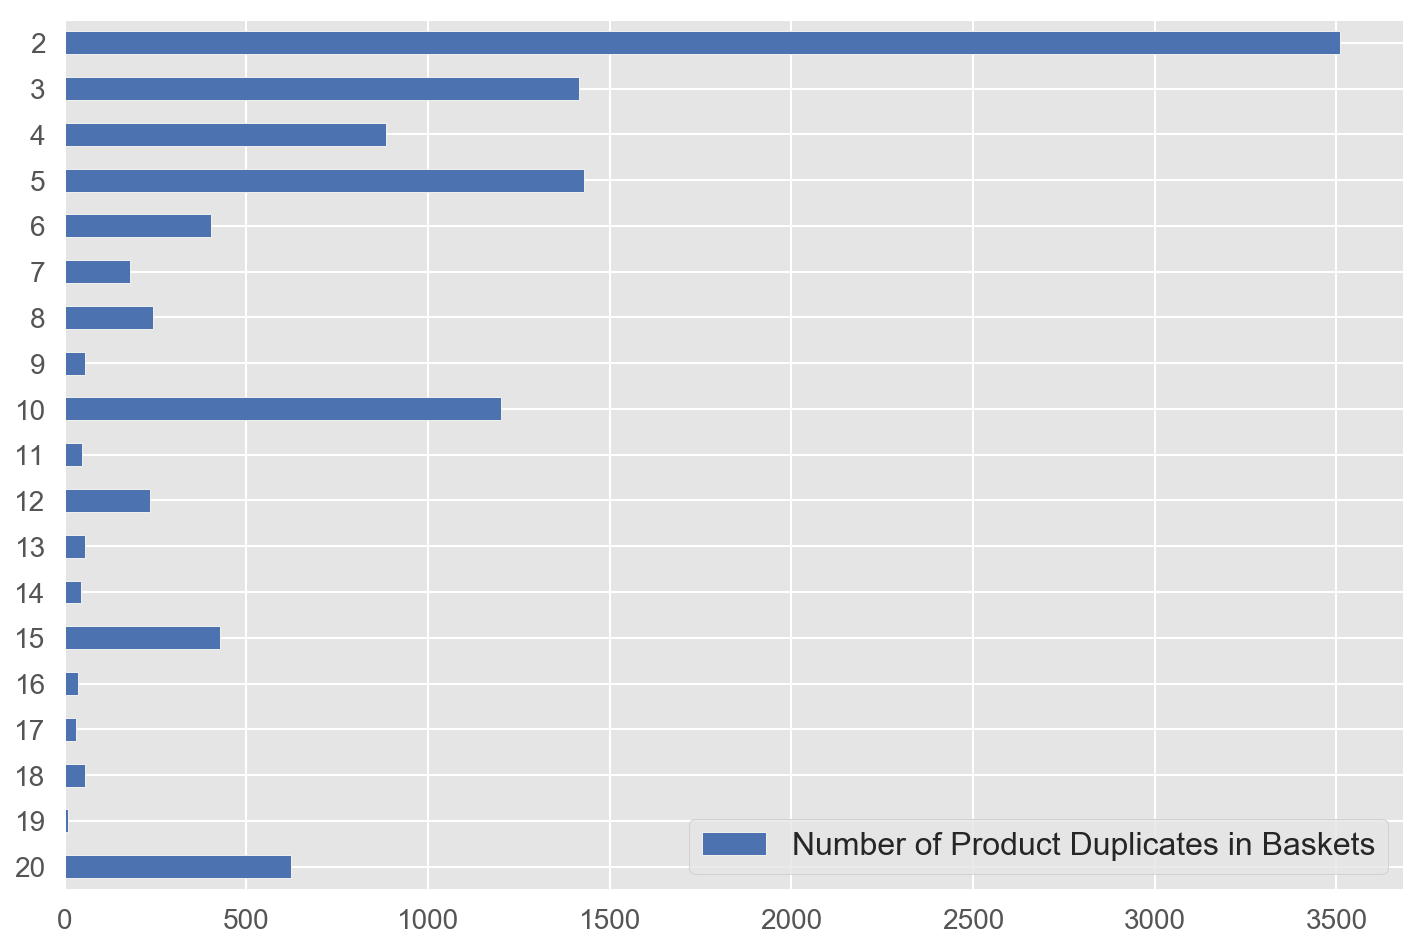

In [193]:
s = df.productQuantity.value_counts().sort_index(ascending=False)
s.name = 'Number of Product Duplicates in Baskets'
pd.DataFrame(index=list(range(2,21))).join(s).iloc[::-1].plot.barh(color='b')
savefig('sales_forecast_product_duplicates')

Most common groups of 2

In [147]:
s = df[df.productQuantity == 2].groupby(['v2ProductName', 'productVariant']).size().sort_values(ascending=False)
s.name = 'Counts'
s.reset_index().set_index('Counts').head()

v2ProductName      productVariant
Counts                                                           
76      Google Laptop and Cell Phone Stickers  Single Option Only
53                          Google Sunglasses                BLUE
51                Engraved Ceramic Google Mug  Single Option Only
49                      YouTube Custom Decals  Single Option Only
48                  Google 22 oz Water Bottle                BLUE

Most common groups of 3

In [149]:
s = df[df.productQuantity == 3].groupby(['v2ProductName', 'productVariant']).size().sort_values(ascending=False)
s.name = 'Counts'
s.reset_index().set_index('Counts').head()

v2ProductName      productVariant
Counts                                                           
40      Google Laptop and Cell Phone Stickers  Single Option Only
33                  Google 22 oz Water Bottle                BLUE
31                             Windup Android  Single Option Only
23                          Google Sunglasses                BLUE
21                  Google 22 oz Water Bottle                 RED

How many _different_ products are purchased together? i.e. final basket sizes

In [198]:
# Add a column for transaction ID
# See docs for more details on this: https://support.google.com/analytics/answer/3437719?hl=en
df['transactionId'] = df['visitId'].astype(str) + '|' + df['fullVisitorId'].astype(str)

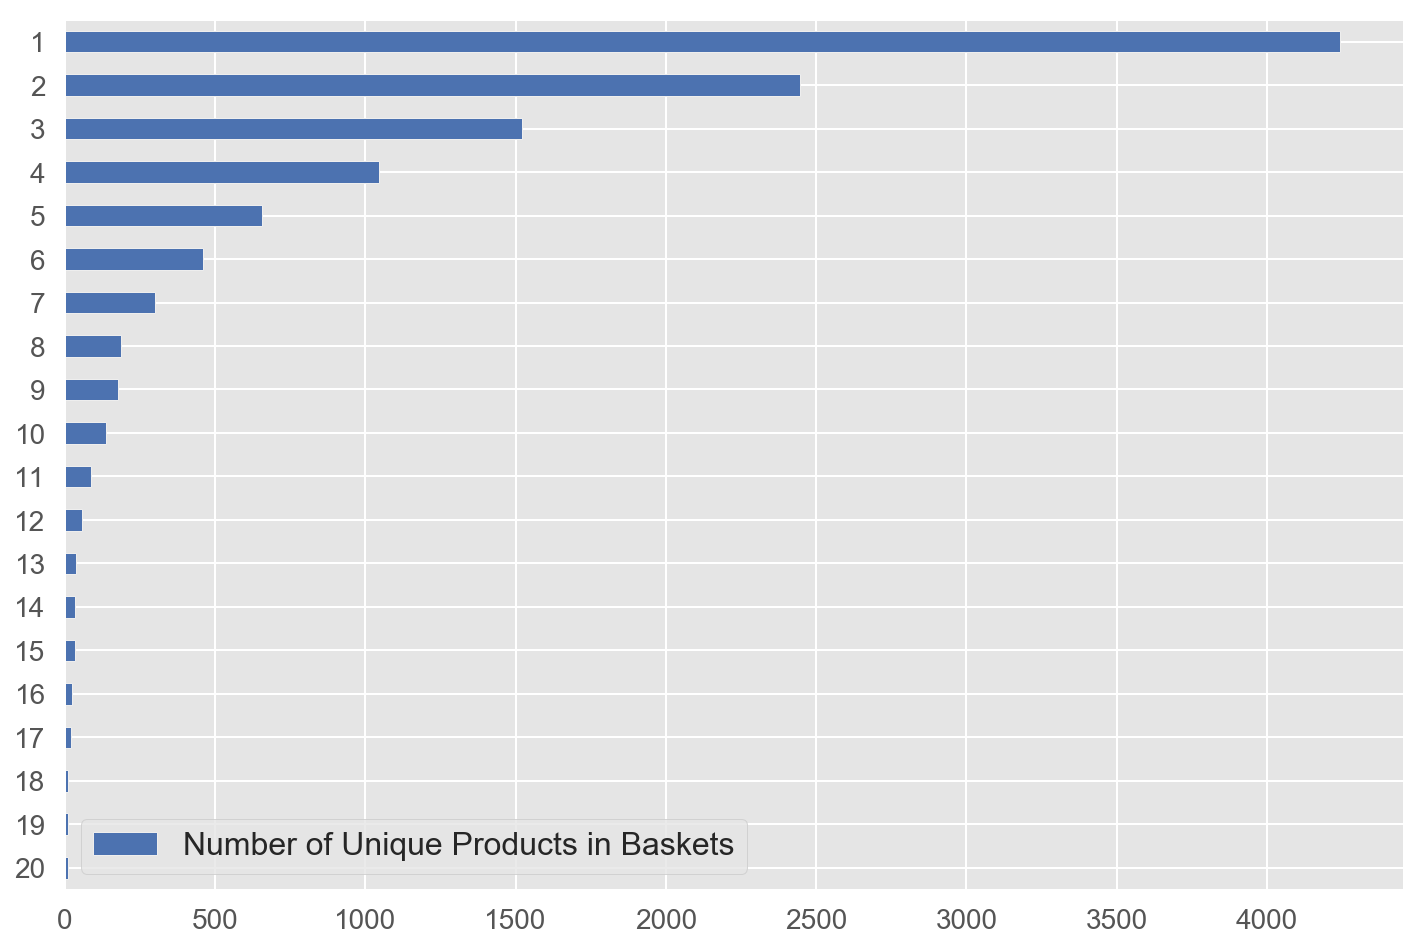

In [199]:
m = ~(df[['transactionId', 'v2ProductName', 'productVariant']].duplicated())
s = df[m].groupby('transactionId').size().value_counts().sort_index(ascending=False)
s.name = 'Number of Unique Products in Baskets'
pd.DataFrame(index=list(range(1,21))).join(s).iloc[::-1].plot.barh(color='b')
savefig('sales_forecast_unique_basket_products')

Which 2 items are most commonly purchased together?

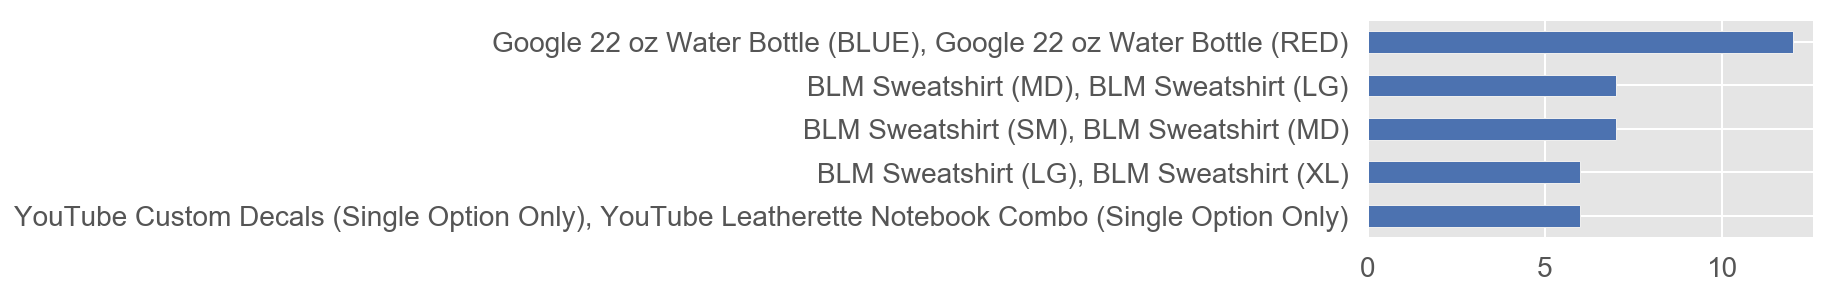

In [205]:
fig = plt.figure(figsize=(4, 2))

m = ~(df[['transactionId', 'v2ProductName', 'productVariant']].duplicated())
s = df[m].groupby('transactionId').size()
transaction_ids = s[s == 2].index.tolist()

pairs = []
for transaction_id in tqdm_notebook(transaction_ids):
    data = df[df.transactionId == transaction_id][['v2ProductName', 'productVariant']].values.tolist()
    if len(data) != 2:
        continue
    
    pair = ', '.join(['{} ({})'.format(d[0].strip(), d[1].strip()) for d in data])
    pairs.append(pair)
    
s = pd.Series(pairs).value_counts(ascending=False)

s.head().iloc[::-1].plot.barh(color='b')

savefig('sales_forecast_product_pairs_1')

Same chart but ignoring product variants

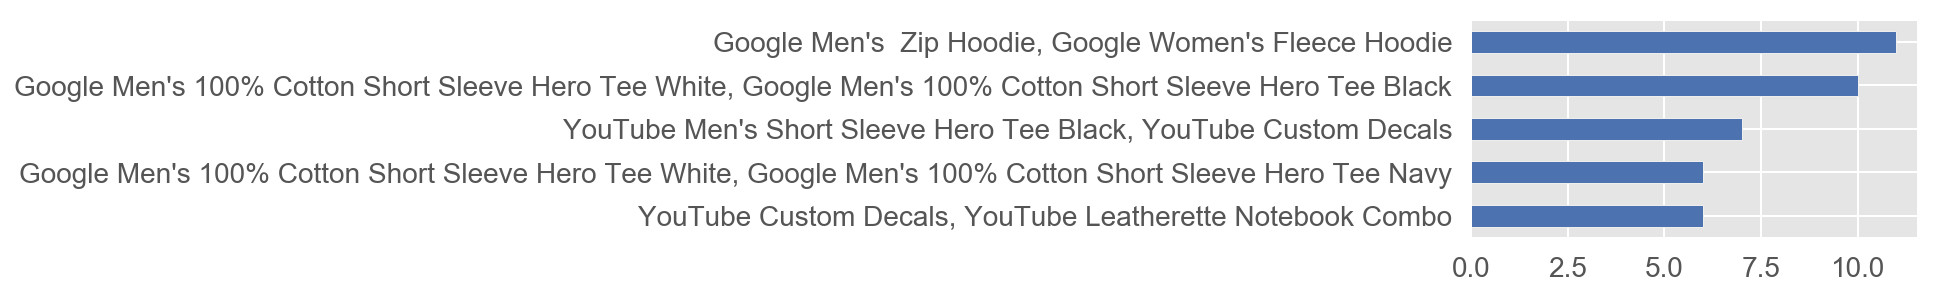

In [207]:
fig = plt.figure(figsize=(4, 2))

m = ~(df[['transactionId', 'v2ProductName']].duplicated())
s = df[m].groupby('transactionId').size()
transaction_ids = s[s == 2].index.tolist()

pairs = []
for transaction_id in tqdm_notebook(transaction_ids):
    data = df[df.transactionId == transaction_id]['v2ProductName'].values.tolist()
    if len(data) != 2:
        continue
    
    pair = ', '.join(data)
    pairs.append(pair)
    
s = pd.Series(pairs).value_counts(ascending=False)

s.head().iloc[::-1].plot.barh(color='b')

savefig('sales_forecast_product_pairs_2')

### Forecasts by product

In general it's difficult to make granular predictions like this on a daily basis. For this reason we will group by week.

In order to help accurately account for anomaly events (e.g. someone places an order for 100 hoddies), I am going to remove outliers (by computing standard deviation and filtering out e.g. `>2s.d.`). Then I'll take that missing revenue and add it back into the quarterly predictions, splitting evenly.

In [115]:
def product_forcast(
    df,
    product_name,
    ignore_std=2,
    yearly_seasonality=10,
    weekly_seasonality=False,
    daily_seasonality=False,
    add_back_outlier_revenue=True,
) -> pd.DataFrame:

    # Filter on product & remove outliers
    df_ = df[df.v2ProductName == product_name].copy()
    m = pd.Series(True, index=df_.index)
    if ignore_std:
        m = df_.productRevenue < (df_.productRevenue.mean() + df_.productRevenue.std()*ignore_std)
        if add_back_outlier_revenue:
            outlier_sum = df_.loc[~m, 'productRevenue'].sum() / 1e6
        else:
            outlier_sum = 0
        print('Ignoring {} outlier points'.format((~m).sum()))
        
    print('Found {} product transactions'.format(m.sum()))
    if m.sum() == 0:
        print('Returning empty DataFrame')
        return pd.DataFrame()
    
    # Group by week
    df_ = (df_[m]
           .groupby(pd.Grouper(key='date', freq='W-MON'))
           .productRevenue.sum().reset_index())

    df_prophet = df_[['date', 'productRevenue']]\
        .rename(columns={'date': 'ds', 'productRevenue': 'y'})
    df_prophet['y'] = df_prophet['y'] / 1e6
    df_prophet['ds'] = df_prophet['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))

    model = Prophet(yearly_seasonality=yearly_seasonality,
                weekly_seasonality=weekly_seasonality,
                daily_seasonality=daily_seasonality)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=52, freq='7D')
    forecast = model.predict(future)
    model.plot(forecast)
    savefig('sales_forecast_{}'.format(slugify(product_name)))
    
    print('Generating quarterly forecasts')
    forecast['date'] = pd.to_datetime(forecast['ds'])
    forecast = add_quarters(forecast)

    m_q = (forecast.quarter != '2016 Q3') & (forecast.quarter != '2018 Q3')
    s_transactions = (
        forecast[m_q].groupby(['quarter_num', 'quarter'])
            .yhat.sum().reset_index()
            .set_index('quarter_num').sort_index(ascending=True)
            .set_index('quarter')['yhat']
    )

    # Get the actual sales (as opposed to predicted above)
    df_ = add_quarters(df_)
    m_q = (df_.quarter != '2016 Q3') & (df_.quarter != '2018 Q3')
    s_actual_productRevenue = (
        df_[m_q].groupby(['quarter_num', 'quarter'])
            .productRevenue.sum().reset_index()
            .set_index('quarter_num').sort_index(ascending=True)
            .set_index('quarter')['productRevenue'] / 1e6
    )

    forecast_results = pd.DataFrame({
        'Reporting Period': ['Q4', 'Q1', 'Q2'],
        'Prev Year': [
            s_actual_productRevenue[s_actual_productRevenue.index=='2016 Q4'].values[0] if (s_actual_productRevenue.index=='2016 Q4').sum() else 0,
            s_actual_productRevenue[s_actual_productRevenue.index=='2017 Q1'].values[0] if (s_actual_productRevenue.index=='2017 Q1').sum() else 0,
            s_actual_productRevenue[s_actual_productRevenue.index=='2017 Q2'].values[0] if (s_actual_productRevenue.index=='2017 Q2').sum() else 0,
        ],
        'Forecasted': [
            s_transactions[s_transactions.index=='2017 Q4'].values[0] + outlier_sum/4,
            s_transactions[s_transactions.index=='2018 Q1'].values[0] + outlier_sum/4,
            s_transactions[s_transactions.index=='2018 Q2'].values[0] + outlier_sum/4,
        ],
    })
    forecast_results['YoY (%)'] = ((forecast_results['Forecasted'] - forecast_results['Prev Year'])
                                    / forecast_results['Prev Year'] * 100).apply(lambda x: '{:+.0f}%'.format(x))
    forecast_results['Prev Year'] = forecast_results['Prev Year'].apply(lambda x: '${:,.0f}'.format(x))
    forecast_results['Forecasted'] = forecast_results['Forecasted'].apply(lambda x: '${:,.0f}'.format(x))
    forecast_results.set_index('Reporting Period', inplace=True)
    forecast_results.to_csv('../../results/tables/sales_forecast_{}.csv'.format(slugify(product_name)))
    
    return forecast, forecast_results, fig

Ignoring 8 outlier points
Found 460 product transactions
Generating quarterly forecasts


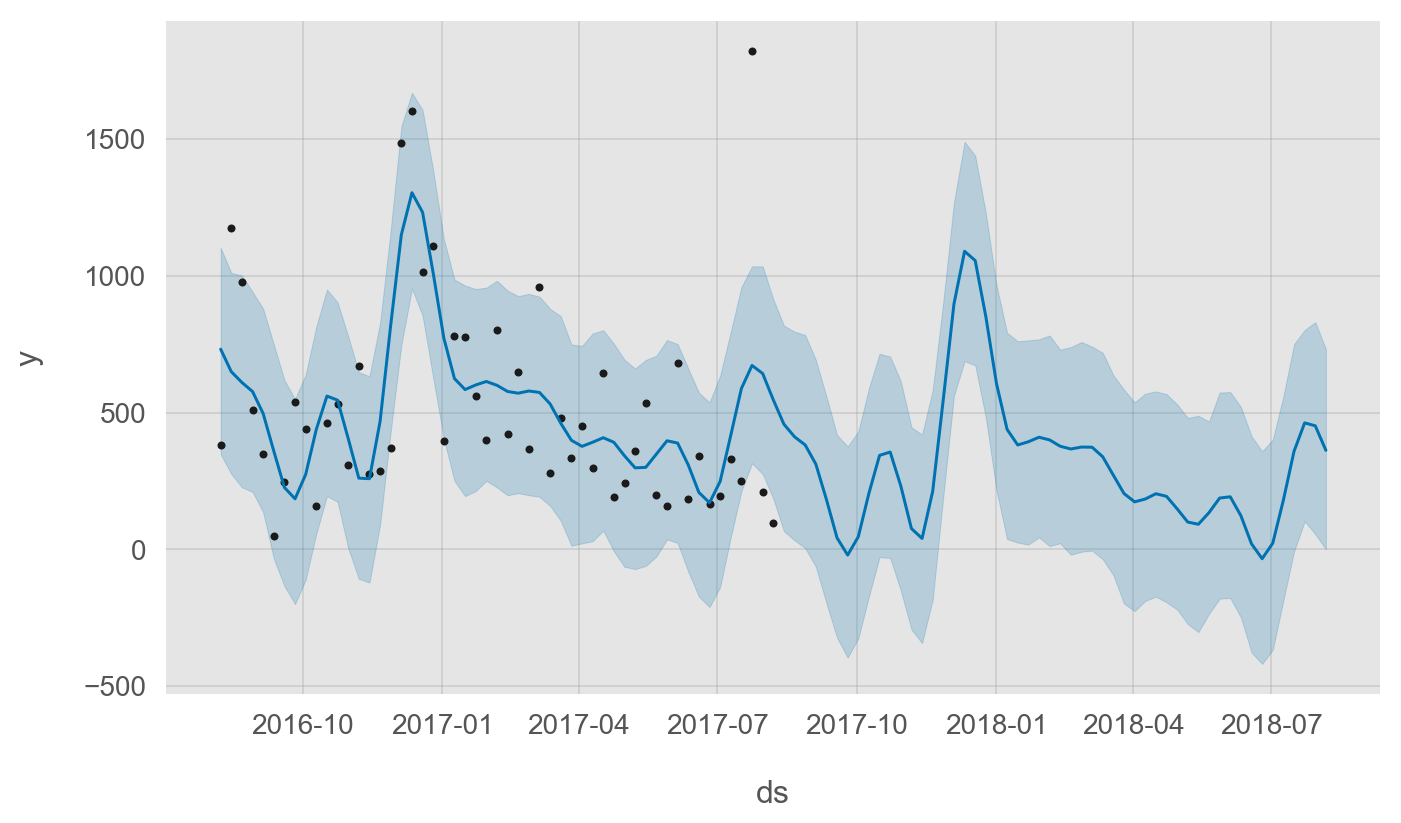

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $8,709    $10,991    +26%
Q1                  $7,208     $9,972    +38%
Q2                  $4,441     $6,754    +52%

In [113]:
forecast, forecast_results, fig = product_forcast(
    df,
    'Google Men\'s  Zip Hoodie',
    yearly_seasonality=8,
)
plt.show()
forecast_results

Run for each of the top 10 Top selling products

--------------------
Google Sunglasses
Ignoring 16 outlier points
Found 1348 product transactions
Generating quarterly forecasts


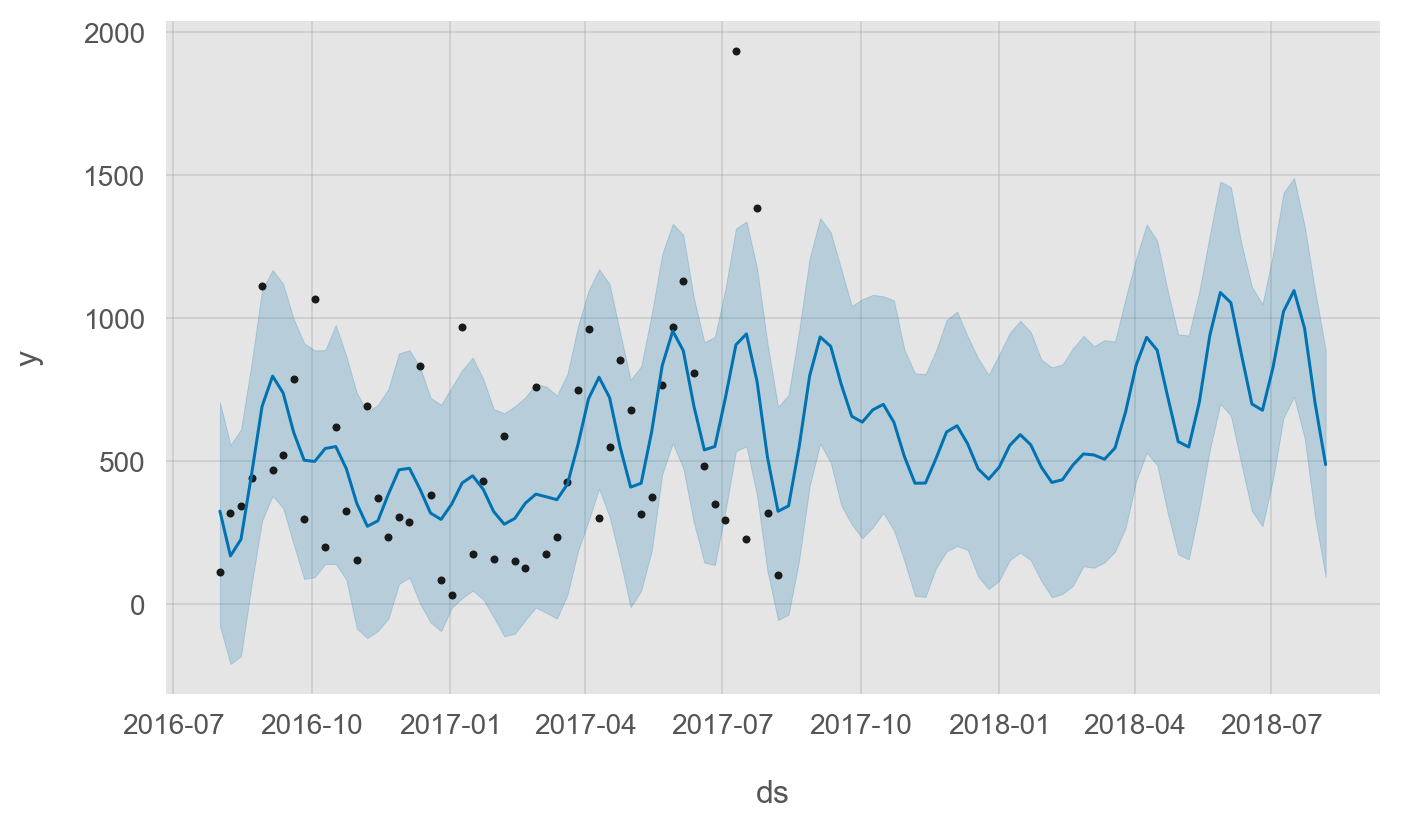

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $5,561     $9,157    +65%
Q1                  $4,979     $8,719    +75%
Q2                  $8,549    $12,478    +46%


--------------------
Google Laptop and Cell Phone Stickers
Ignoring 25 outlier points
Found 763 product transactions
Generating quarterly forecasts


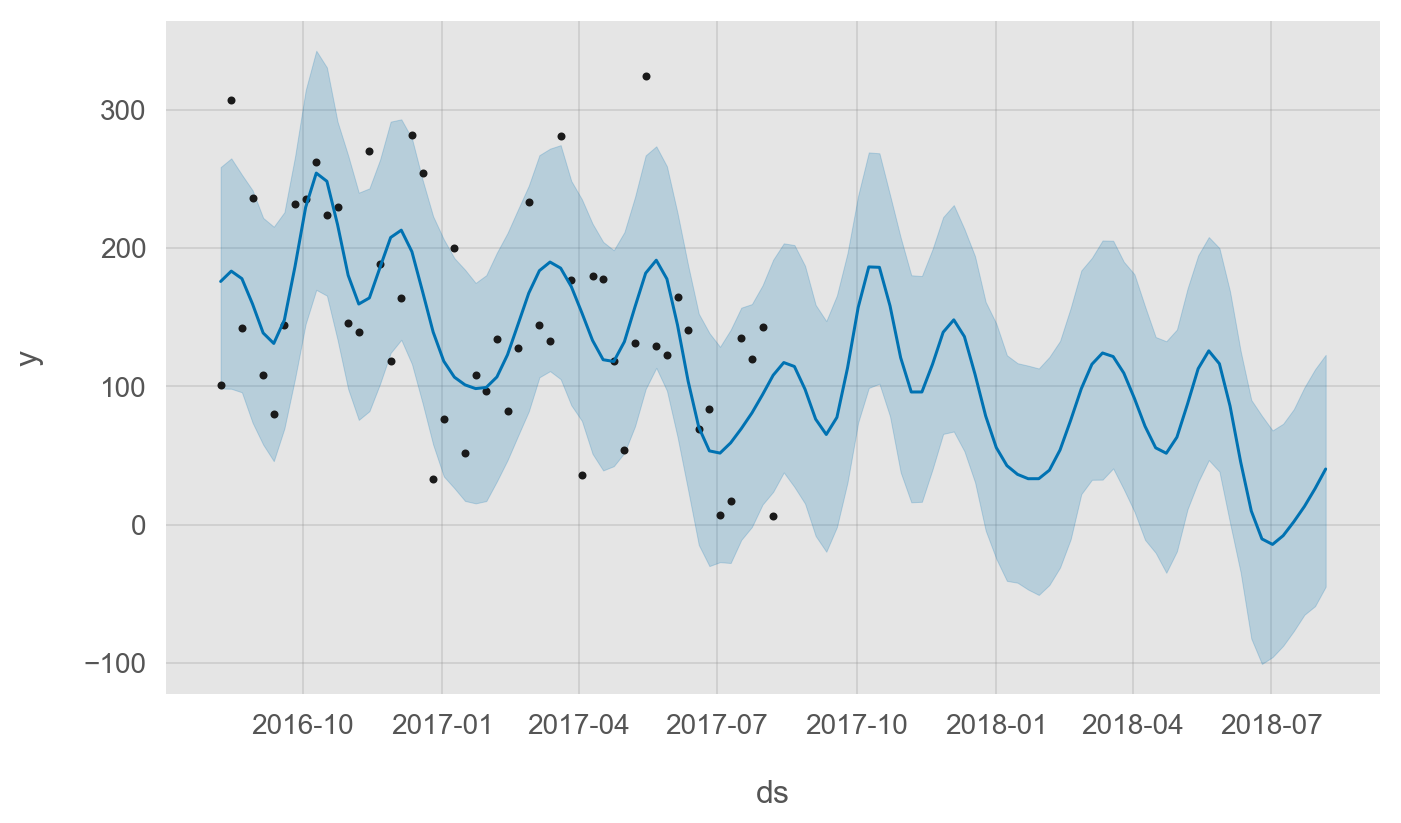

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $2,545     $2,853    +12%
Q1                  $1,845     $2,066    +12%
Q2                  $1,731     $2,032    +17%


--------------------
Google 22 oz Water Bottle
Ignoring 18 outlier points
Found 766 product transactions
Generating quarterly forecasts


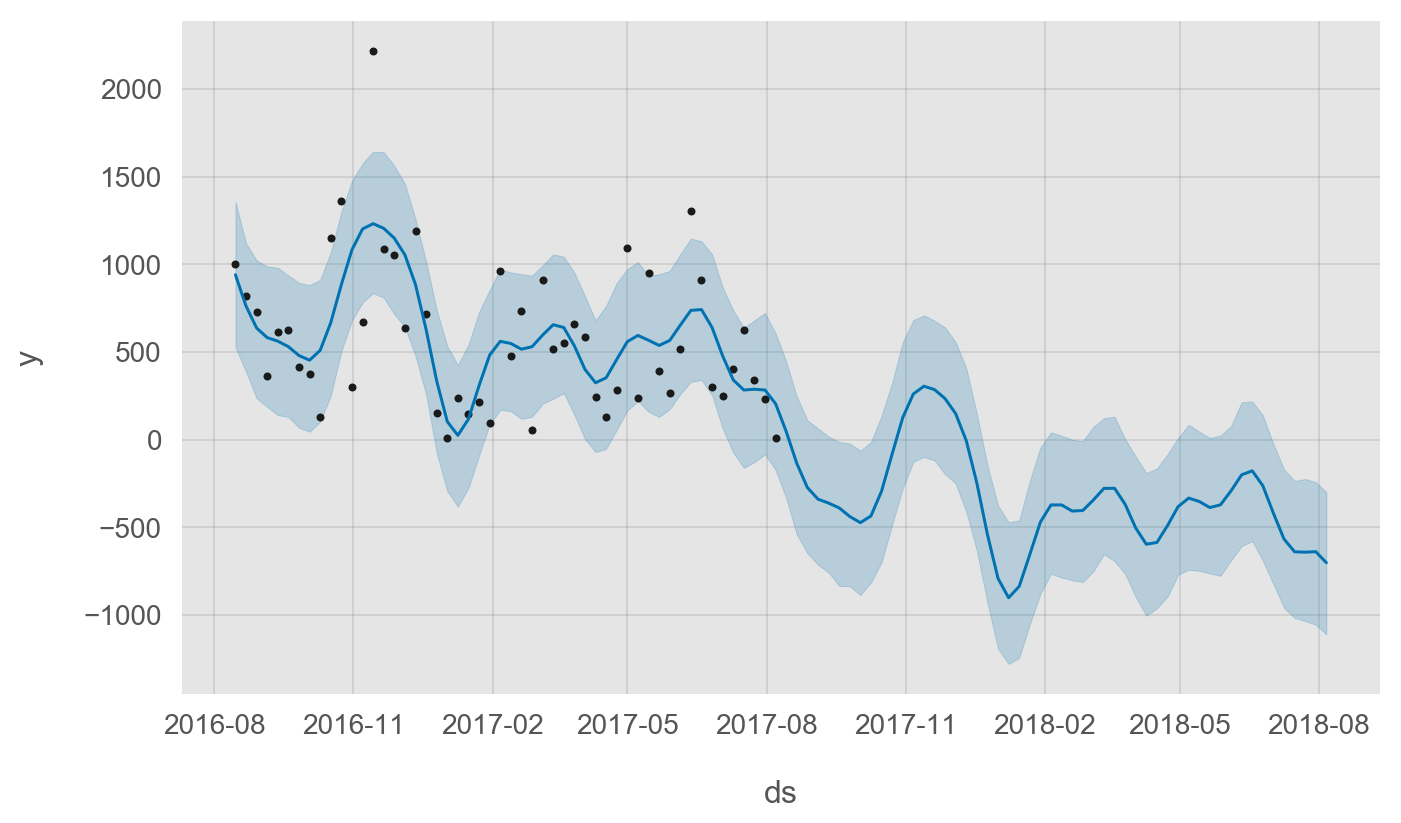

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                 $11,051     $2,468    -78%
Q1                  $5,580    $-3,289   -159%
Q2                  $7,215    $-1,747   -124%


--------------------
Google Men's 100% Cotton Short Sleeve Hero Tee White
Ignoring 14 outlier points
Found 746 product transactions
Generating quarterly forecasts


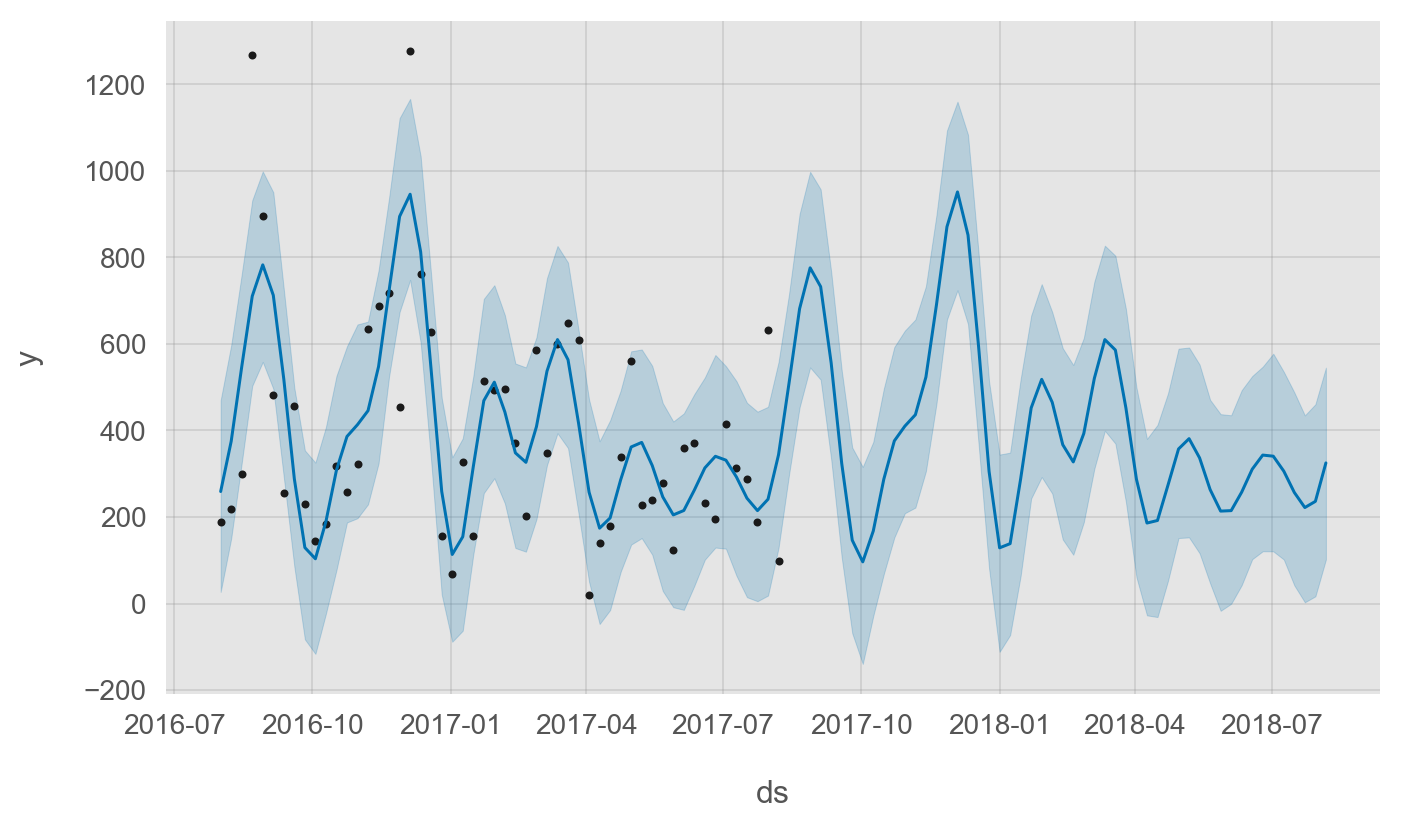

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $6,543     $8,161    +25%
Q1                  $5,421     $6,846    +26%
Q2                  $3,261     $5,217    +60%


--------------------
Google Men's 100% Cotton Short Sleeve Hero Tee Black
Ignoring 12 outlier points
Found 703 product transactions
Generating quarterly forecasts


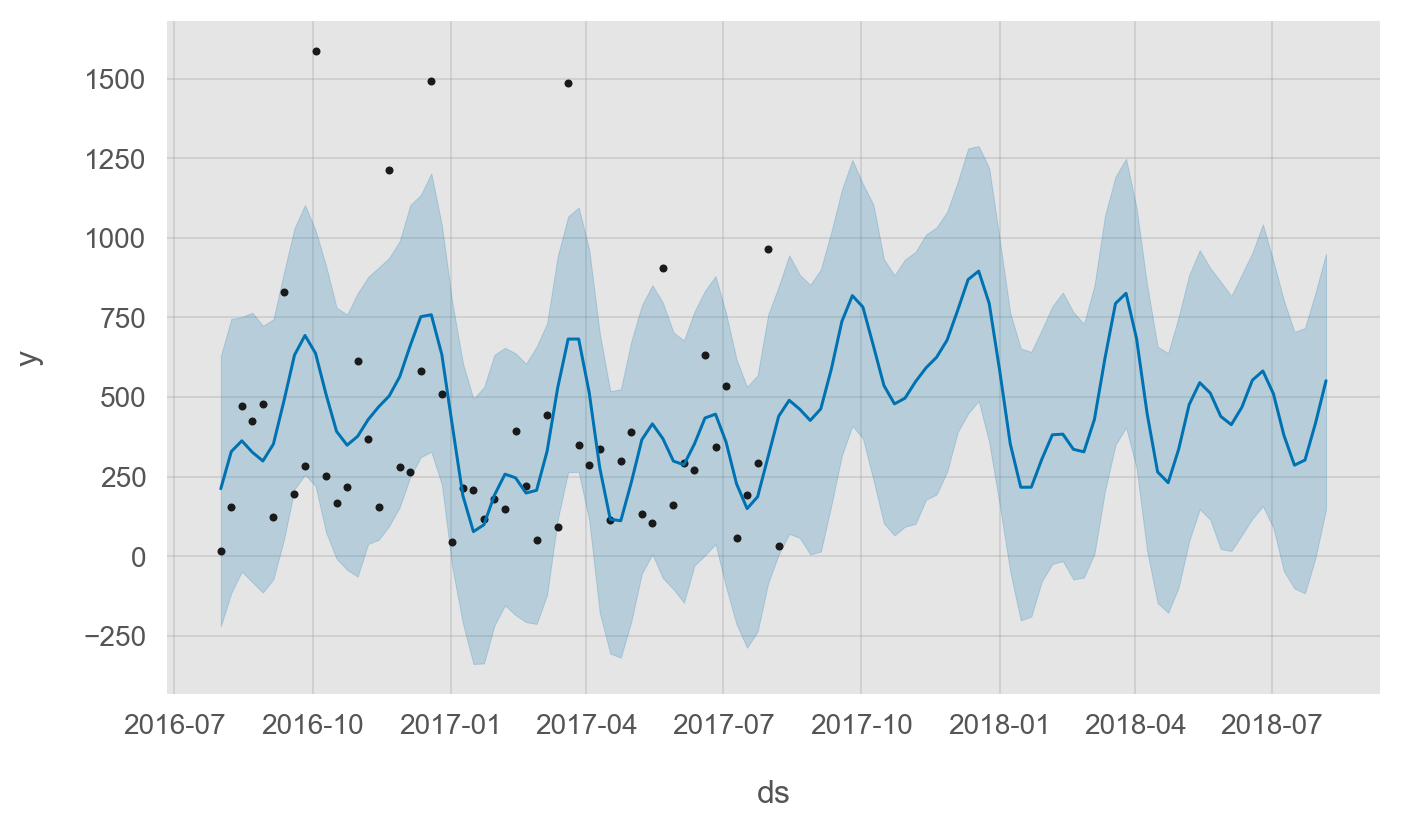

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $7,706    $10,499    +36%
Q1                  $3,948     $7,544    +91%
Q2                  $4,266     $7,723    +81%


--------------------
Google Men's 100% Cotton Short Sleeve Hero Tee Navy
Ignoring 7 outlier points
Found 554 product transactions
Generating quarterly forecasts


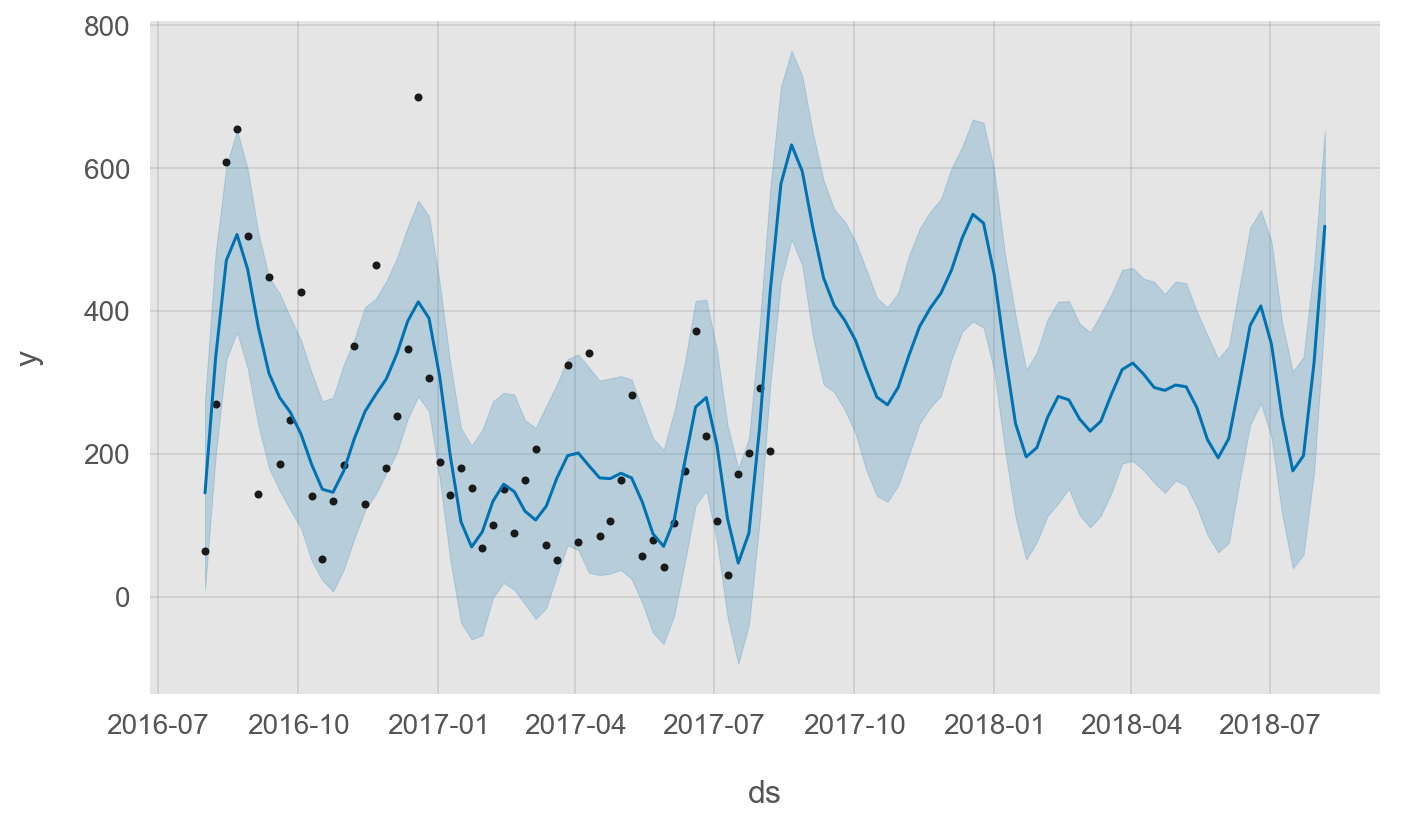

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $3,671     $5,484    +49%
Q1                  $1,890     $3,978   +110%
Q2                  $2,110     $4,200    +99%


--------------------
Google Men's  Zip Hoodie
Ignoring 8 outlier points
Found 460 product transactions
Generating quarterly forecasts


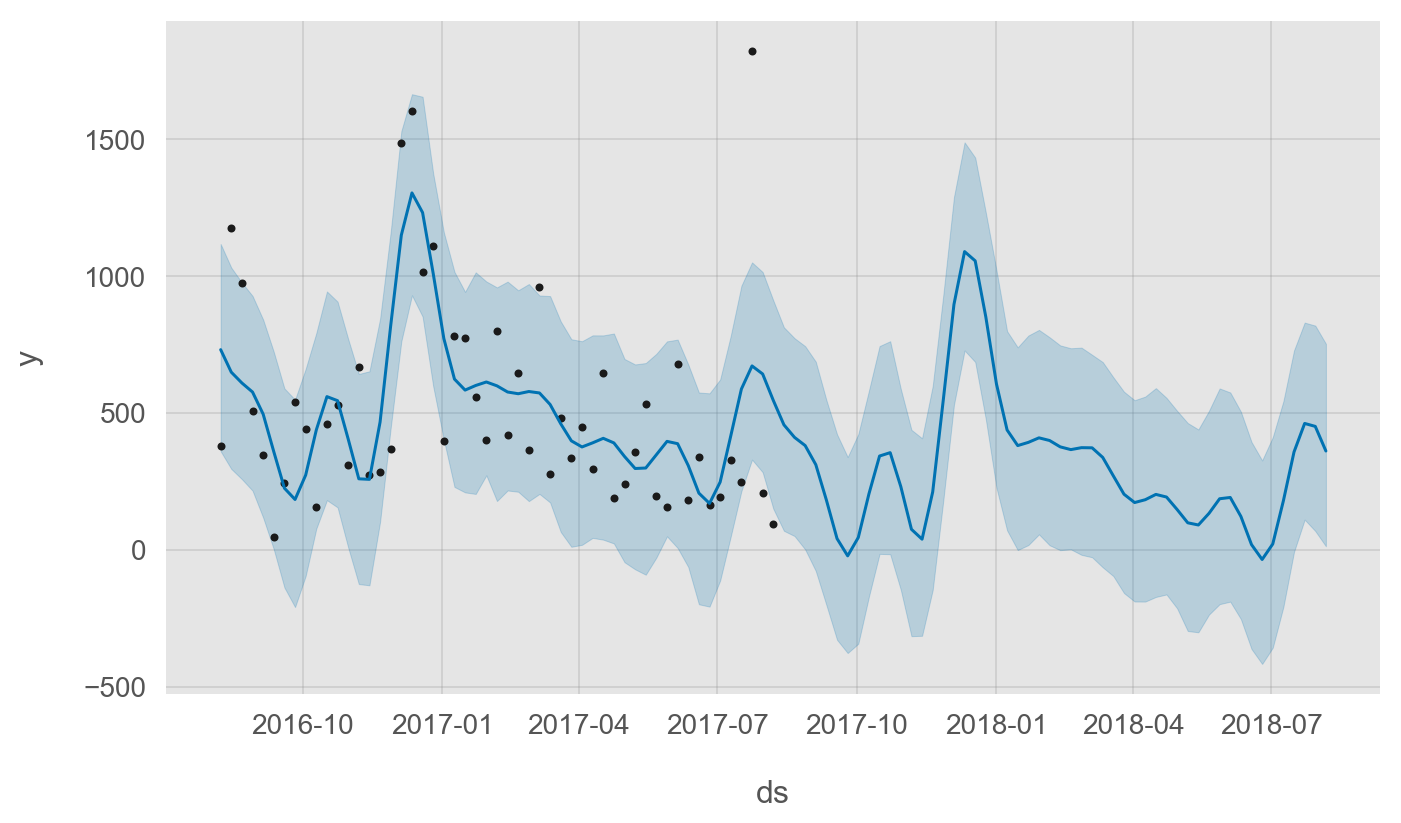

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $8,709    $10,991    +26%
Q1                  $7,208     $9,972    +38%
Q2                  $4,441     $6,754    +52%


--------------------
Recycled Paper Journal Set
Ignoring 21 outlier points
Found 410 product transactions
Generating quarterly forecasts


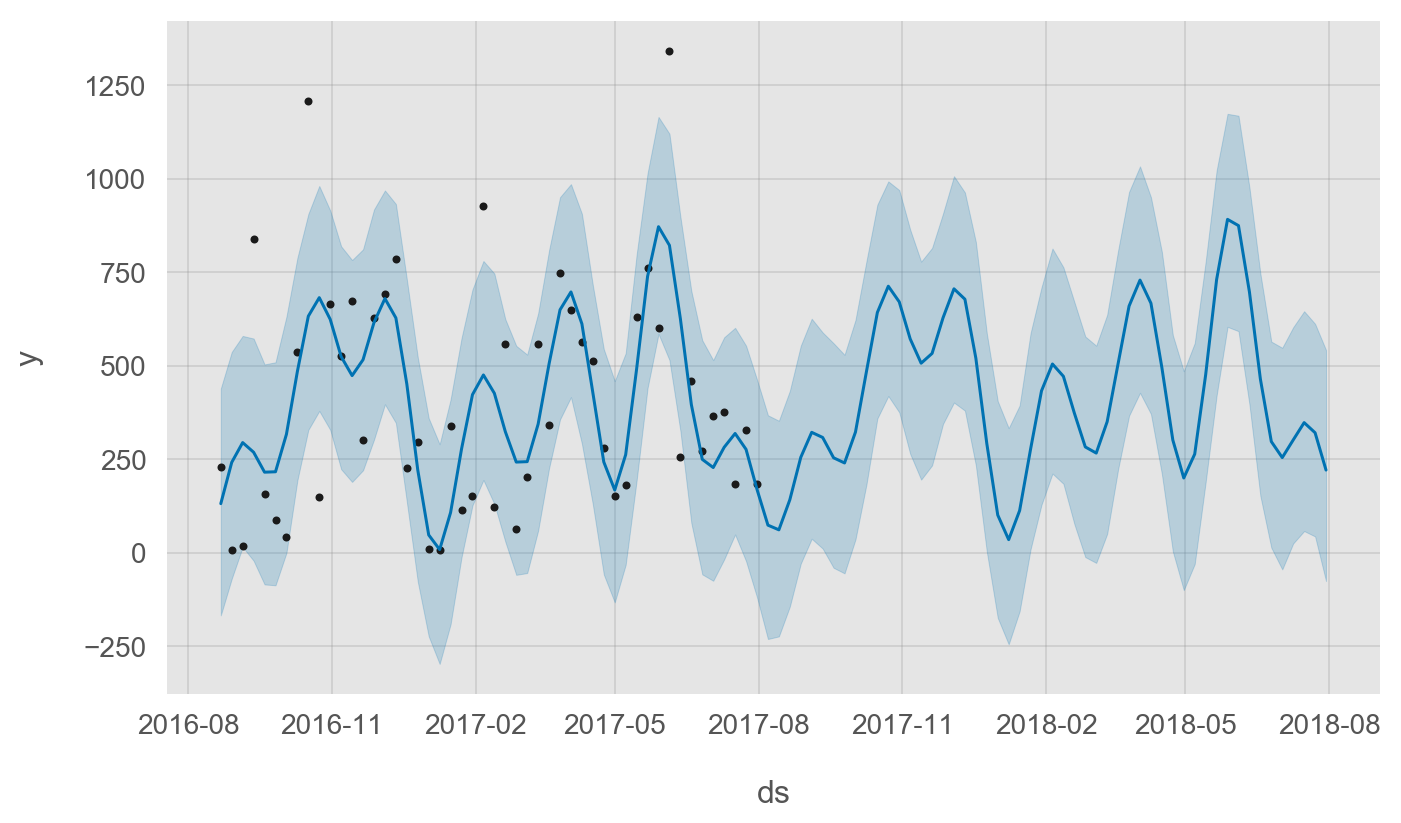

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $6,731     $9,171    +36%
Q1                  $4,153     $6,276    +51%
Q2                  $6,668     $8,990    +35%

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.



--------------------
BLM Sweatshirt
Ignoring 13 outlier points
Found 392 product transactions
Generating quarterly forecasts


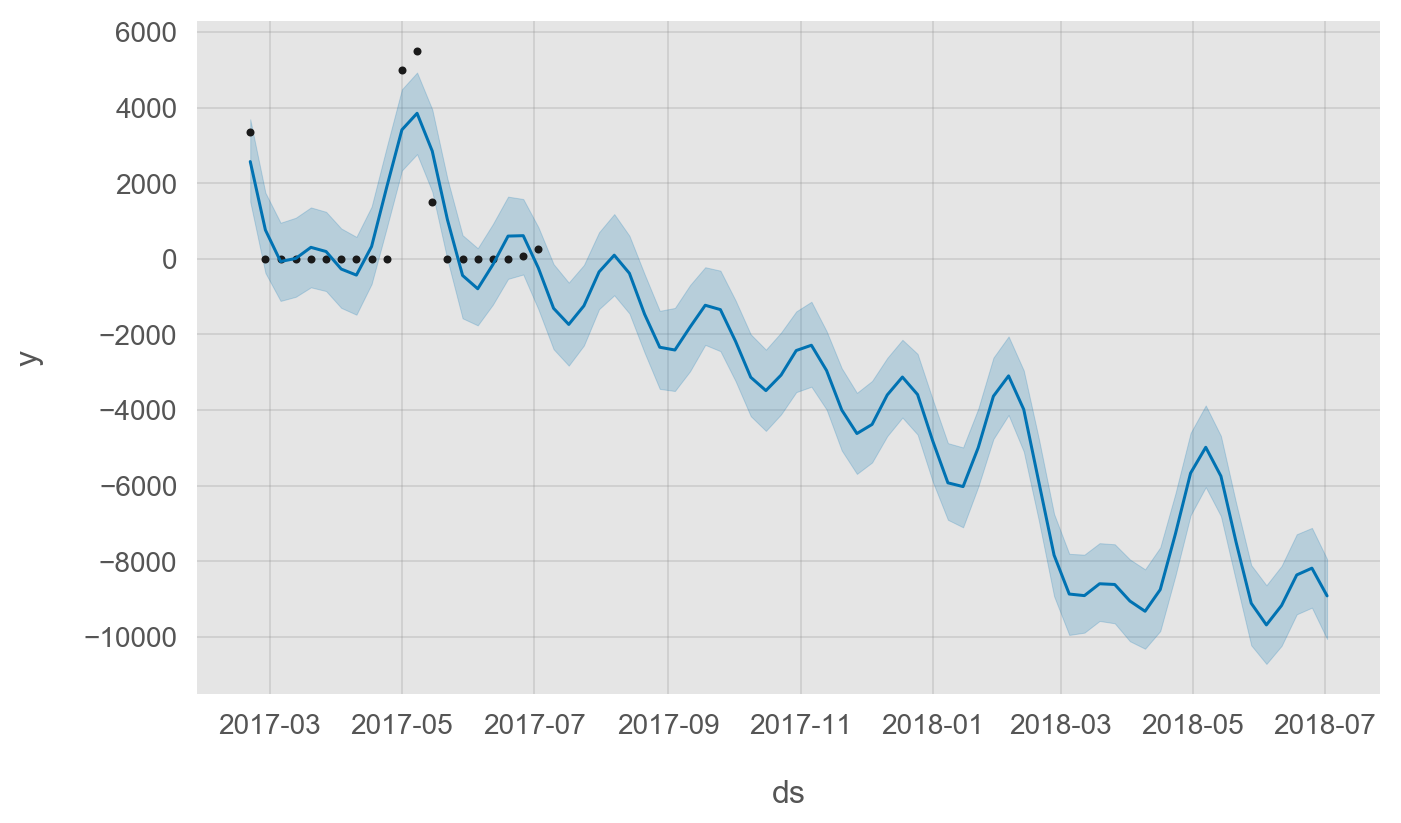

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                      $0   $-42,447   -inf%
Q1                  $3,363   $-80,804  -2503%
Q2                 $12,085  $-102,395   -947%


--------------------
Engraved Ceramic Google Mug
Ignoring 13 outlier points
Found 387 product transactions
Generating quarterly forecasts


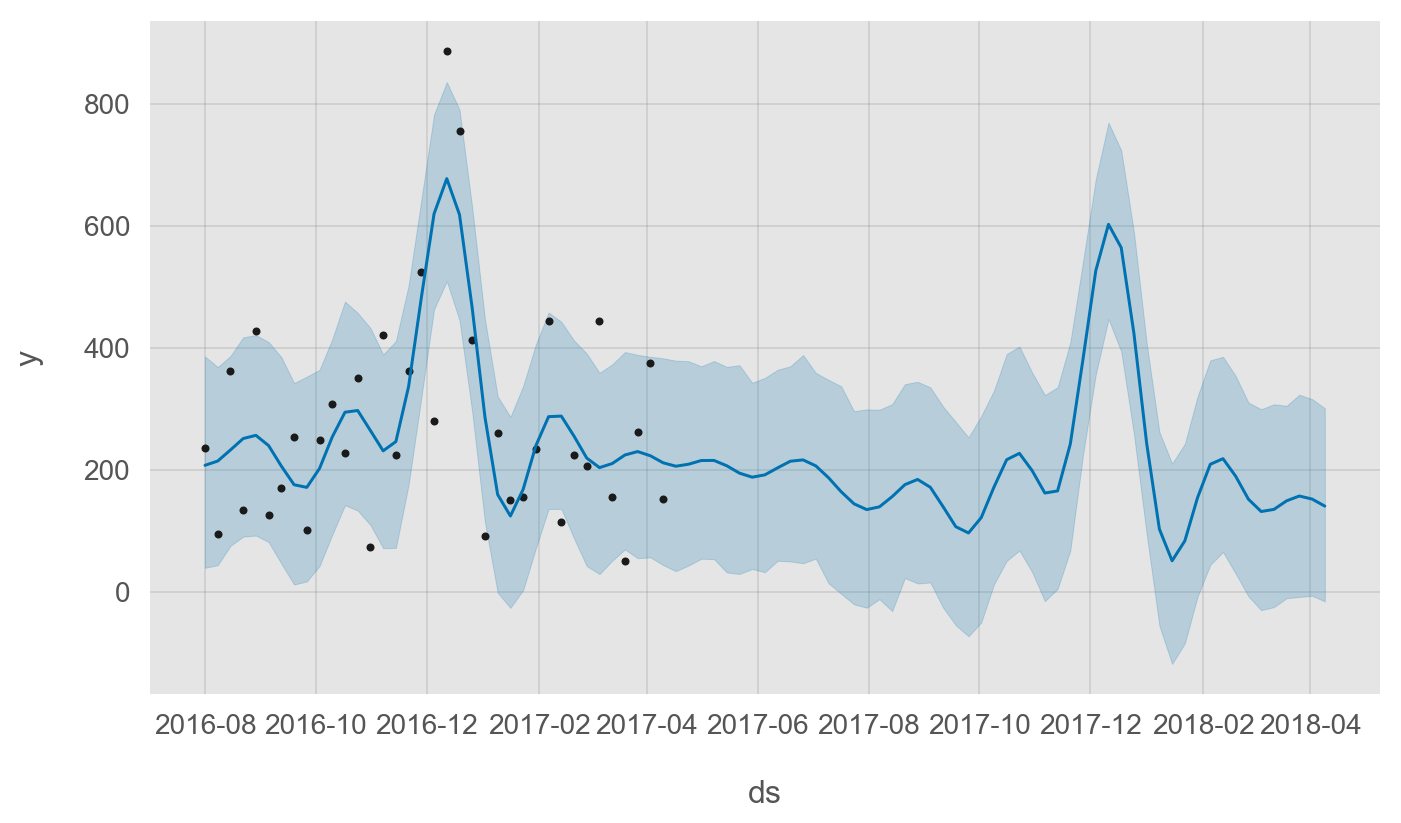

Prev Year Forecasted YoY (%)
Reporting Period                             
Q4                  $5,076     $5,875    +16%
Q1                  $2,789     $3,848    +38%
Q2                    $526     $2,166   +312%

In [116]:
for product in df.v2ProductName.value_counts(ascending=False).head(10).index.tolist():
    print('-'*20)
    print(Fore.RED + product + Style.RESET_ALL)
    forecast, forecast_results, fig = product_forcast(
        df,
        product,
        yearly_seasonality=8,
    )
    plt.show()
    display(forecast_results)
    print()

In [117]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')